# Introduction

**Who are our customers? Who should we target with marketing efforts? Who deserves the most attractive deals?**

The objective of this notebook is to explore these questions by analyzing The Complete Journey dataset. This comprehensive dataset includes transactions from 2,500 households over a span of 711 days, along with demographic information for a subset of these customers.

By delving into this dataset, we aim to gain valuable insights about customer behavior and demographics to inform targeted marketing strategies.

For more information about the dataset, visit the [Visit Complete Journey](https://cran.r-project.org/web/packages/completejourney/index.html)


# Import Libraries

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib_venn import venn3
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load Dataset
Load the dataset into a DataFrame.
Display the first few rows to get an overview

In [5]:
# Please edit the file path for your specific machine. The first CSV we will be looking at is hh_demographic.csv


file_path = r" INSERT PATH HERE \hh_demographic.csv"


hh_demographic=pd.read_csv(file_path)
# Convert all column names to lowercase
hh_demographic.columns = hh_demographic.columns.str.lower()
hh_demographic.head()

age_desc marital_status_code income_desc homeowner_desc      hh_comp_desc  \
0      65+                   A      35-49K      Homeowner  2 Adults No Kids   
1    45-54                   A      50-74K      Homeowner  2 Adults No Kids   
2    25-34                   U      25-34K        Unknown     2 Adults Kids   
3    25-34                   U      75-99K      Homeowner     2 Adults Kids   
4    45-54                   B      50-74K      Homeowner     Single Female   

  household_size_desc kid_category_desc  household_key  
0                   2      None/Unknown              1  
1                   2      None/Unknown              7  
2                   3                 1              8  
3                   4                 2             13  
4                   1      None/Unknown             16

# Lets look at the demographics of the customers and see what we can find 

# Initial Dataset Exploration

In [8]:
hh_demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age_desc             801 non-null    object
 1   marital_status_code  801 non-null    object
 2   income_desc          801 non-null    object
 3   homeowner_desc       801 non-null    object
 4   hh_comp_desc         801 non-null    object
 5   household_size_desc  801 non-null    object
 6   kid_category_desc    801 non-null    object
 7   household_key        801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


We only have demographc information on 801 of the households. Can see we are not missing any data of these 801 households. The datatypes might be a issue but lets first check and see if there is any repeat households in the data

In [10]:
# Checking to see if there are any duplicated household keys
(hh_demographic['household_key'].value_counts()>1).value_counts()

count
False    801
Name: count, dtype: int64

No repeats, lets now see what values are in each column

In [12]:
print("\nUnique values in categorical columns:")
categorical_cols = hh_demographic.select_dtypes(include=['object']).columns
for col in categorical_cols:
        print(f"\nUnique values in '{col}':")
        print(hh_demographic[col].unique())


Unique values in categorical columns:

Unique values in 'age_desc':
['65+' '45-54' '25-34' '35-44' '19-24' '55-64']

Unique values in 'marital_status_code':
['A' 'U' 'B']

Unique values in 'income_desc':
['35-49K' '50-74K' '25-34K' '75-99K' 'Under 15K' '100-124K' '15-24K'
 '125-149K' '150-174K' '250K+' '175-199K' '200-249K']

Unique values in 'homeowner_desc':
['Homeowner' 'Unknown' 'Renter' 'Probable Renter' 'Probable Owner']

Unique values in 'hh_comp_desc':
['2 Adults No Kids' '2 Adults Kids' 'Single Female' 'Unknown'
 'Single Male' '1 Adult Kids']

Unique values in 'household_size_desc':
['2' '3' '4' '1' '5+']

Unique values in 'kid_category_desc':
['None/Unknown' '1' '2' '3+']


Can see why we have object type for a few of these seemingly numeric columns as there is a 5+ and 3+. No need to change datatypes yet. Note for marital_status_code  A= Married, B= Single, U= Unknown, lets change this so we don't have to remember this later

In [14]:
# Map the marital status codes to their actual meanings
marital_status_mapping = {
    'A': 'Married',
    'B': 'Single',
    'U': 'Unknown'
}

# Replace the values in the 'marital_status_code' column
hh_demographic['marital_status_code'] = hh_demographic['marital_status_code'].replace(marital_status_mapping)

In [15]:
hh_demographic.head()

age_desc marital_status_code income_desc homeowner_desc      hh_comp_desc  \
0      65+             Married      35-49K      Homeowner  2 Adults No Kids   
1    45-54             Married      50-74K      Homeowner  2 Adults No Kids   
2    25-34             Unknown      25-34K        Unknown     2 Adults Kids   
3    25-34             Unknown      75-99K      Homeowner     2 Adults Kids   
4    45-54              Single      50-74K      Homeowner     Single Female   

  household_size_desc kid_category_desc  household_key  
0                   2      None/Unknown              1  
1                   2      None/Unknown              7  
2                   3                 1              8  
3                   4                 2             13  
4                   1      None/Unknown             16

# Graphing

Our data looks good. Now its time to visualize the customers based on demographics known, first by bar graphs and then pie charts

## Bar Graphs

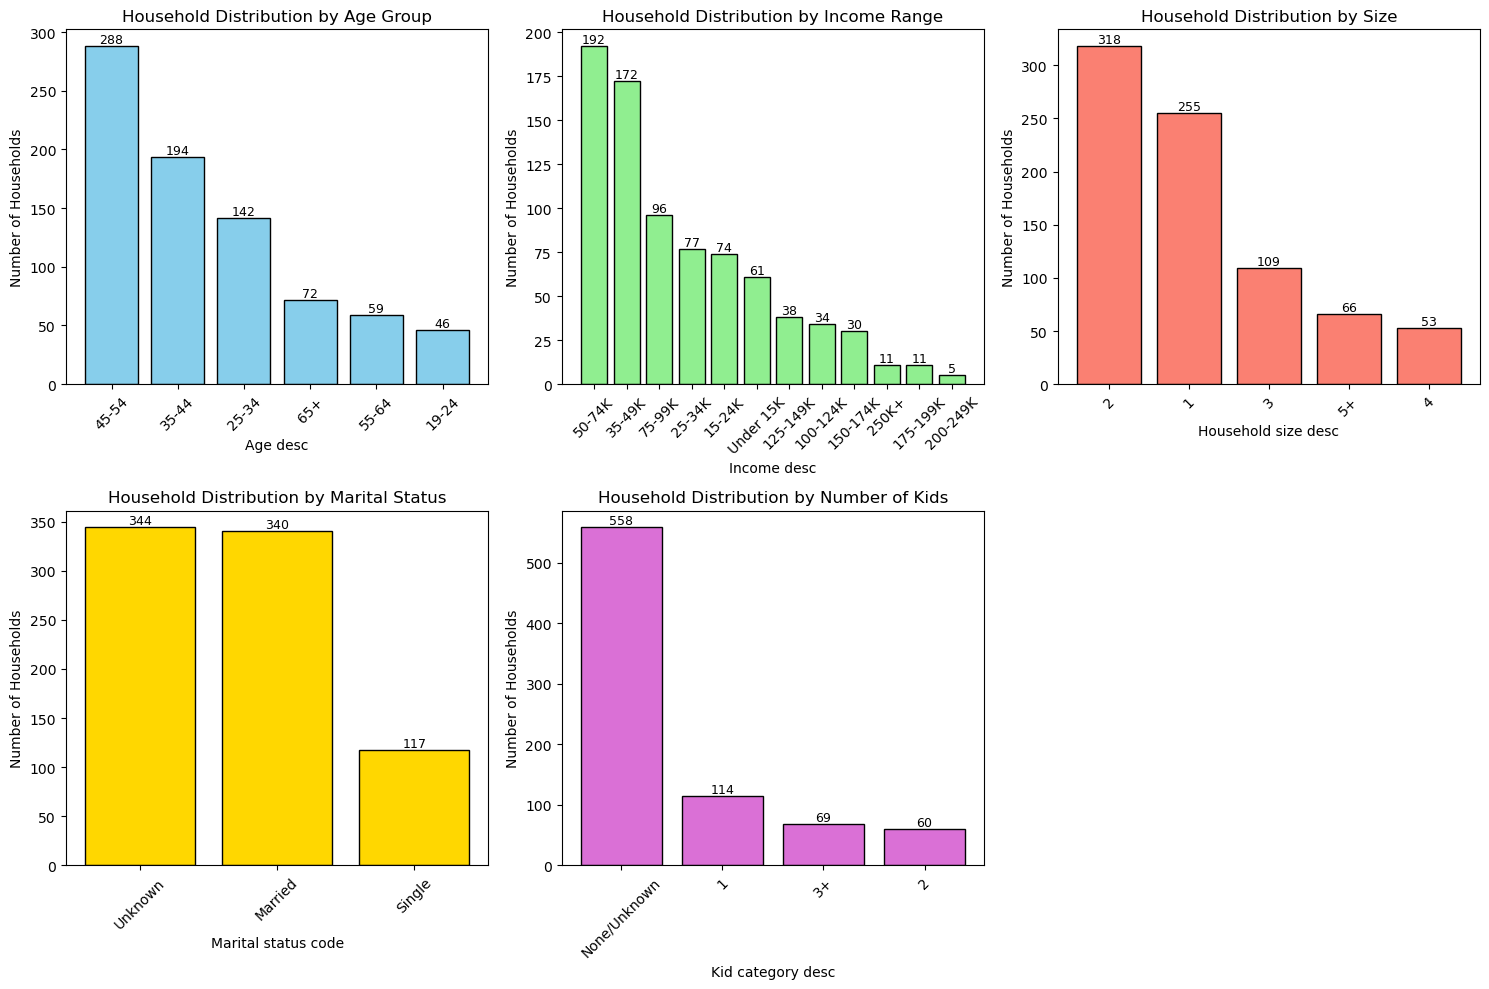

In [18]:
# List of categorical columns and their titles
categorical_columns = {
    'age_desc': 'Household Distribution by Age Group',
    'income_desc': 'Household Distribution by Income Range',
    'household_size_desc': 'Household Distribution by Size',
    'marital_status_code': 'Household Distribution by Marital Status',
    'kid_category_desc': 'Household Distribution by Number of Kids'
}

# Generate a list of unique colors for each graph
color_palette = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'cyan']

# Create a grid layout for the bar graphs
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the axes for easier iteration

# Generate bar charts for each category
for i, (column, title) in enumerate(categorical_columns.items()):
    if i < len(axes):  # Ensure we only iterate within available axes
        # Count the distribution of the category
        distribution = hh_demographic[column].value_counts()
        
        # Assign a unique color to the chart
        color = color_palette[i % len(color_palette)]
        
        # Plot bar chart
        bars = axes[i].bar(distribution.index, distribution.values, color=color, edgecolor='black')
        axes[i].set_title(title, fontsize=12)
        axes[i].set_xlabel(column.replace('_', ' ').capitalize(), fontsize=10)
        axes[i].set_ylabel('Number of Households', fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)

        # Add counts on top of each bar
        for bar in bars:
            height = bar.get_height()
            axes[i].text(
                bar.get_x() + bar.get_width() / 2,  # Center text horizontally
                height,  # Position text at the top of the bar
                f'{int(height)}',  # Convert height to integer
                ha='center', va='bottom', fontsize=9, color='black'
            )

# Remove any empty plots if the grid size exceeds the number of charts
for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


## Pie Charts

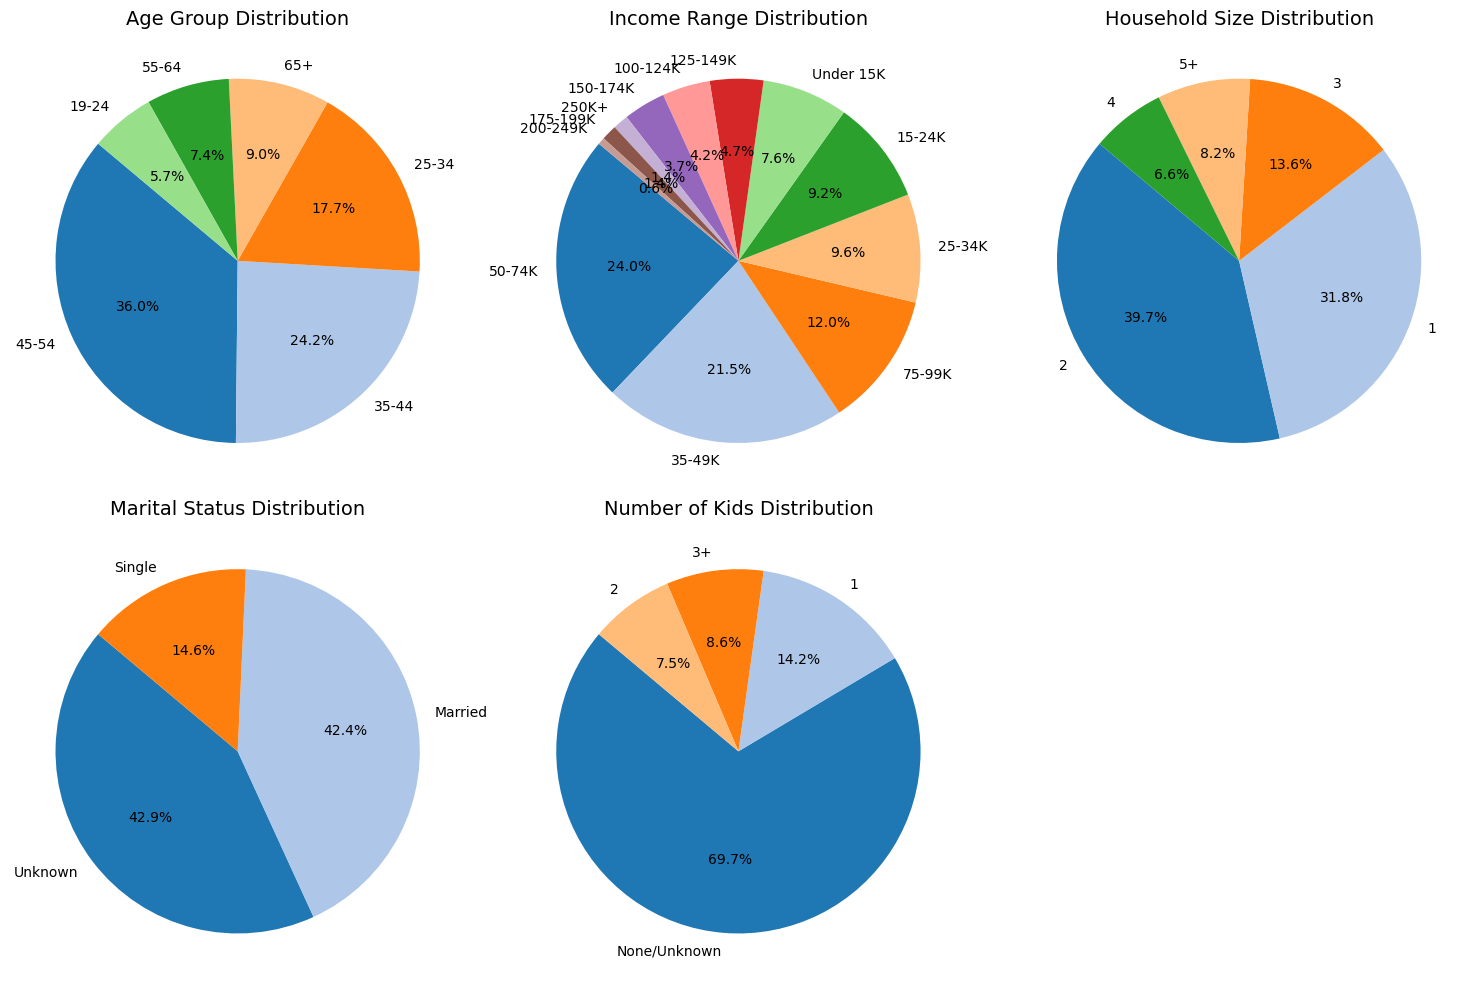

In [20]:
# List of categorical columns and their titles
categorical_columns = {
    'age_desc': 'Age Group Distribution',
    'income_desc': 'Income Range Distribution',
    'household_size_desc': 'Household Size Distribution',
    'marital_status_code': 'Marital Status Distribution',
    'kid_category_desc': 'Number of Kids Distribution'
}

# Create a grid layout for the pie charts
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the axes for easier iteration

# Generate pie charts for each category
for i, (column, title) in enumerate(categorical_columns.items()):
    if i < len(axes):  # Ensure we only iterate within available axes
        # Count the distribution of the category
        distribution = hh_demographic[column].value_counts()
        
        # Plot pie chart
        axes[i].pie(
            distribution, 
            labels=distribution.index, 
            autopct='%1.1f%%', 
            startangle=140, 
            colors=plt.cm.tab20.colors[:len(distribution)]  # Use tab20 colormap for distinct colors

        )
        axes[i].set_title(title, fontsize=14)

# Remove any empty plots if the grid size exceeds the number of charts
for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()



# Findings so far

### Age Distribution
The largest age group is 45-54 (288 households), followed by 35-44 (194 households).
The youngest group, 19-24, is the smallest (46 households), while 65+ represents 72 households.
### Marital Status
The majority of households have unknown marital status (344 households).
Married households total 340, slightly fewer than unknown.
Single households are the smallest group (117).
### Income Distribution
The most common income ranges are 50-74K (192 households) and 35-49K (172 households).
Lower income ranges like 15-24K (74) and Under 15K (61) are more frequent than higher ranges like 175-199K (11) or 200-249K (5).
The least represented income group is 250K+ (11 households).
### Homeownership
Homeowners form the majority (504 households).
A significant portion has an unknown ownership status (233 households).
Only a small number are renters (42) or probable owners/renters (22 combined).
### Household Composition
Most households consist of 2 Adults with No Kids (255), followed by 2 Adults with Kids (187).
Single Female households (144) outnumber Single Male households (95).
Smaller groups include 1 Adult with Kids (47) and unknown compositions (73).
### Household Size
Two-person households dominate (318), followed by single-person households (255).
Larger households (5+ people) are relatively rare (66), with four-person households being the smallest group (53).
### Kid Category
A significant majority (558 households) have no kids or unknown status.
Households with 1 child (114) are more common than those with 2 children (60) or 3+ children (69).
This summary highlights the population's key demographic and household traits, emphasizing age, marital status, income, homeownership, composition, size, and presence of children.

# Finding Relationships between categories 

Lets see what relationships exist between demographic categories

## Categorize Columns to Define Order

In [24]:
# Define the custom order for 'age_desc'
age_order = ['19-24' ,'25-34','35-44','45-54' ,'55-64', '65+']

# Apply the custom order to the 'income_desc' column
hh_demographic['age_desc'] = pd.Categorical(
    hh_demographic['age_desc'],
    categories=age_order,
    ordered=True
)
#############

# Define the custom order for 'marital_status_code'
marital_status_order = ['Married','Single','Unknown']

# Apply the custom order to the 'income_desc' column
hh_demographic['marital_status_code'] = pd.Categorical(
    hh_demographic['marital_status_code'],
    categories=marital_status_order,
    ordered=True
)
#############

# Define the custom order for 'homeowner_desc'
homeowner_desc_order = ['Homeowner','Probable Owner', 'Renter','Probable Renter','Unknown']

# Apply the custom order to the 'income_desc' column
hh_demographic['homeowner_desc'] = pd.Categorical(
    hh_demographic['homeowner_desc'],
    categories=homeowner_desc_order,
    ordered=True
)
#############

# Define the custom order for 'hh_comp_desc'
hh_comp_desc_order = ['Single Male','Single Female', '2 Adults No Kids', '1 Adult Kids','2 Adults Kids','Unknown']

# Apply the custom order to the 'income_desc' column
hh_demographic['hh_comp_desc'] = pd.Categorical(
    hh_demographic['hh_comp_desc'],
    categories=hh_comp_desc_order,
    ordered=True
)
###############

# Define the custom order for 'household_size_desc'
household_size_order = ['1', '2', '3', '4', '5+']

# Apply the custom order to the 'income_desc' column
hh_demographic['household_size_desc'] = pd.Categorical(
    hh_demographic['household_size_desc'],
    categories=household_size_order,
    ordered=True
)
################

# Define the custom order for 'kid_category_desc'
kid_category_order = ['None/Unknown', '1' ,'2', '3+']

# Apply the custom order to the 'income_desc' column
hh_demographic['kid_category_desc'] = pd.Categorical(
    hh_demographic['kid_category_desc'],
    categories=kid_category_order,
    ordered=True
)
################

# Define the custom order for 'income_desc'
income_order = [
    'Under 15K', '15-24K', '25-34K', '35-49K', '50-74K', 
    '75-99K', '100-124K', '125-149K', '150-174K', 
    '175-199K', '200-249K', '250K+'
]

# Apply the custom order to the 'income_desc' column
hh_demographic['income_desc'] = pd.Categorical(
    hh_demographic['income_desc'],
    categories=income_order,
    ordered=True
)

## Create Heatmaps with Consistent Axis Patterns

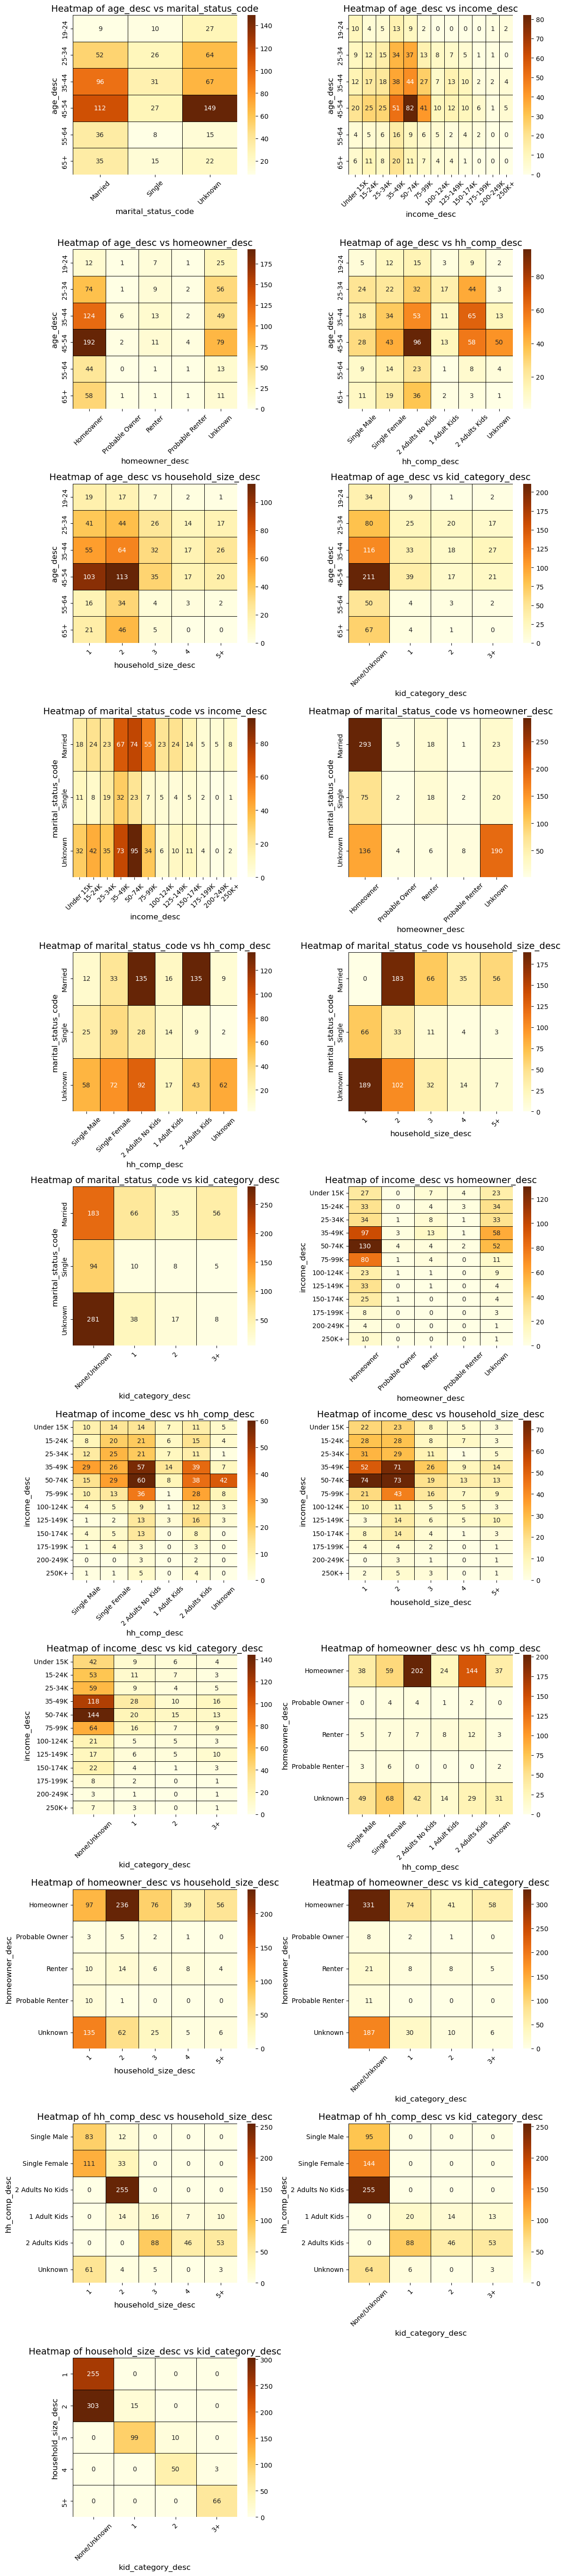

In [26]:
# List of categorical columns
categorical_cols = [
    'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc', 
    'hh_comp_desc', 'household_size_desc', 'kid_category_desc'
]

# Generate all possible pairs of categories
category_pairs = list(combinations(categorical_cols, 2))

# Define the number of columns for the grid
num_columns = 2
num_rows = len(category_pairs) // num_columns + (1 if len(category_pairs) % num_columns != 0 else 0)

# Create a grid layout for the heatmaps
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, num_rows * 5))

# Flatten axes for easier indexing
axes = axes.flatten()

# Loop through pairs and plot heatmaps
for i, (cat1, cat2) in enumerate(category_pairs):
    # Create pivot table
    pivot_table = hh_demographic.groupby([cat1, cat2], observed=False).size().unstack(fill_value=0)
    
    # Plot the heatmap
    sns.heatmap(
        pivot_table,
        cmap=sns.color_palette("YlOrBr", as_cmap=True),
        annot=True,
        fmt='d',
        linewidths=0.5,
        linecolor='black',
        cbar=True,
        ax=axes[i]
    )
    axes[i].set_title(f"Heatmap of {cat1} vs {cat2}", fontsize=14)
    axes[i].set_xlabel(cat2, fontsize=12)
    axes[i].set_ylabel(cat1, fontsize=12)
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)

# Remove any empty subplots if the number of category pairs is less than the grid size
for j in range(len(category_pairs), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


# Observations
### Dominance of "Unknown" or "Probable" Categories:
Several categories (e.g., marital_status_code, income_desc, and kid_category_desc) contain a significant proportion of "Unknown" values, while homeowner_desc includes "Probable" as a label. These may represent missing data, default categories, or classifications requiring further clarification.

### Age and Household Characteristics:

The majority of households in the 45-54 age group are homeowners, with "2 Adults No Kids" as the most common composition. This suggests that middle-aged homeowners often live in smaller households.
Younger groups (25-34 and 35-44) show more variation, with higher counts in categories like "2 Adults Kids" and renting.

### Income Distribution by Household Size:

Moderate income levels (50-74K and 35-49K) are the most prevalent across different household sizes, particularly for 1- or 2-person households.
Households with 5+ members tend to have income levels skewed slightly higher, suggesting a possible correlation between family size and income.

### Kid Categories and Household Sizes:

Smaller households (size 1 or 2) overwhelmingly have "None/Unknown" in kid_category_desc. Larger households (3+) correlate with having children.

### Marital Status and Household Composition:

Married individuals frequently belong to "2 Adults No Kids" or "2 Adults Kids" households, while singles are more likely in "Single Female" or "Single Male" categories.

# Identifying Top Spenders: Analyzing Transaction Data

In [29]:
# **Please edit the file path for your specific machine. The second CSV we will be looking at is transaction_data_lean.csv**

file_path = r" INSERT PATH HERE \transaction_data_lean.csv"

transaction_data=pd.read_csv(file_path)
# Convert all column names to lowercase
transaction_data.columns = transaction_data.columns.str.lower()
transaction_data.head()

household_key    basket_id  day  product_id  quantity  sales_value  \
0           2375  26984851472    1     1004906         1         1.39   
1           2375  26984851472    1     1033142         1         0.82   
2           2375  26984851472    1     1036325         1         0.99   
3           2375  26984851472    1     1082185         1         1.21   
4           2375  26984851472    1     8160430         1         1.50   

   retail_disc  
0        -0.60  
1         0.00  
2        -0.30  
3         0.00  
4        -0.39

EDA before getting started

In [31]:
transaction_data.describe()

household_key     basket_id           day    product_id      quantity  \
count   2.595732e+06  2.595732e+06  2.595732e+06  2.595732e+06  2.595732e+06   
mean    1.271953e+03  3.402620e+10  3.887562e+02  2.891435e+06  1.004286e+02   
std     7.260660e+02  4.711649e+09  1.897210e+02  3.837404e+06  1.153436e+03   
min     1.000000e+00  2.698485e+10  1.000000e+00  2.567100e+04  0.000000e+00   
25%     6.560000e+02  3.040805e+10  2.290000e+02  9.174590e+05  1.000000e+00   
50%     1.272000e+03  3.276081e+10  3.900000e+02  1.028816e+06  1.000000e+00   
75%     1.913000e+03  4.012685e+10  5.530000e+02  1.133018e+06  1.000000e+00   
max     2.500000e+03  4.230536e+10  7.110000e+02  1.831630e+07  8.963800e+04   

        sales_value   retail_disc  
count  2.595732e+06  2.595732e+06  
mean   3.104120e+00 -5.387054e-01  
std    4.182274e+00  1.249191e+00  
min    0.000000e+00 -1.800000e+02  
25%    1.290000e+00 -6.900000e-01  
50%    2.000000e+00 -1.000000e-02  
75%    3.490000e+00  0.000000e+00  
max    8.400000e+02  3.990000e+00

In [32]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595732 entries, 0 to 2595731
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   household_key  int64  
 1   basket_id      int64  
 2   day            int64  
 3   product_id     int64  
 4   quantity       int64  
 5   sales_value    float64
 6   retail_disc    float64
dtypes: float64(2), int64(5)
memory usage: 138.6 MB


In [33]:
transaction_data.isnull().sum()

household_key    0
basket_id        0
day              0
product_id       0
quantity         0
sales_value      0
retail_disc      0
dtype: int64

No missing data, dtypes all look good

In [35]:
# Filter transaction_data to include only rows with household_key in hh_demographic
transaction_data_known_households = transaction_data[transaction_data['household_key'].isin(hh_demographic['household_key'])]

transaction_data_known_households.head()

household_key    basket_id  day  product_id  quantity  sales_value  \
11           1364  26984896261    1      842930         1         2.19   
12           1364  26984896261    1      897044         1         2.99   
13           1364  26984896261    1      920955         1         3.09   
14           1364  26984896261    1      937406         1         2.50   
15           1364  26984896261    1      981760         1         0.60   

    retail_disc  
11         0.00  
12        -0.40  
13         0.00  
14        -0.99  
15        -0.79

In [36]:
# Sanity check- do we have 801 households after filtering the transiction data with the demographic data household key?
transaction_data_known_households['household_key'].nunique()

801

In [58]:
# Individual basket_id's are trips to the store. Lets group by household_key and count the basket_id 
# Note, not summing the quantity column as there are some items with a quanity in the 10k range,
# instead count the product id's as a rough estimation for total_items
transaction_groupby_known_household = transaction_data_known_households.groupby('household_key').agg(
    total_trips=('basket_id', 'nunique'),
    total_sales=('sales_value', 'sum'),
    total_items=('product_id','count'), 
    total_retail_disc=('retail_disc', 'sum')   
)

In [60]:
transaction_groupby_known_household.head()

total_trips  total_sales  total_items  total_retail_disc
household_key                                                          
1                       86      4330.16         1727            -697.04
7                       59      3400.05         1286            -482.51
8                      113      5534.97         1979           -1078.30
13                     275     13190.92         2348           -1627.19
16                      98      1512.02          517            -171.29

In [62]:
transaction_groupby_known_household.describe()

total_trips   total_sales  total_items  total_retail_disc
count   801.000000    801.000000   801.000000         801.000000
mean    175.204744   5615.126417  1781.901373        -952.935044
std     130.901673   3750.938675  1086.895236         646.274040
min      22.000000    646.400000   233.000000       -4668.590000
25%      96.000000   2970.100000   996.000000       -1224.440000
50%     139.000000   4676.430000  1510.000000        -793.180000
75%     214.000000   7164.990000  2330.000000        -503.980000
max    1223.000000  27859.680000  6851.000000         -57.670000

# Graphing

Lets visualize this new grouped dataset

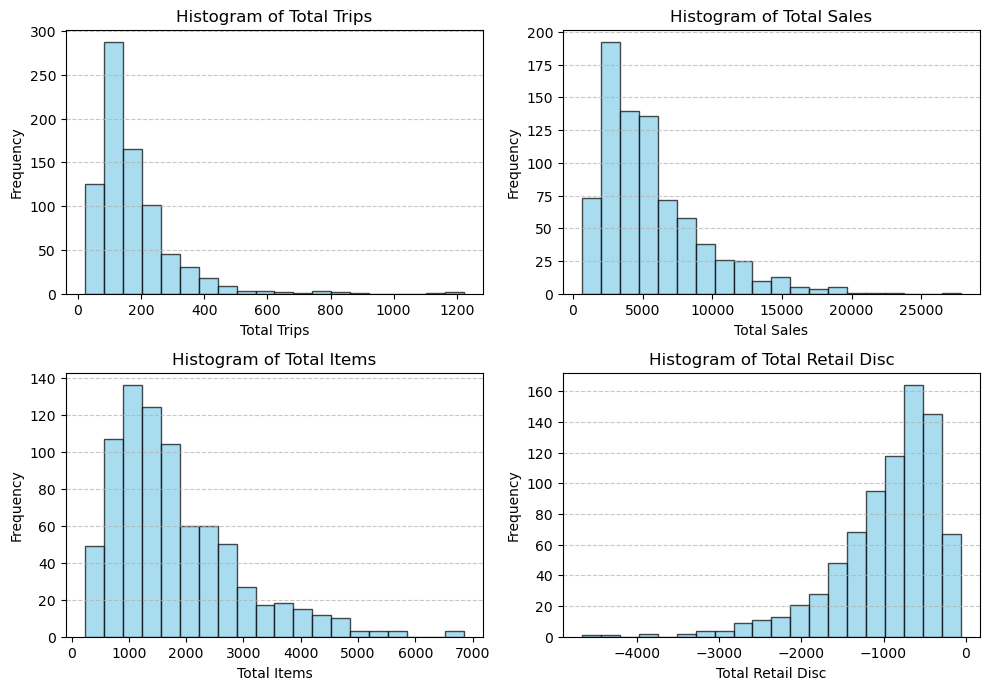

In [65]:
# List of columns to create histograms for
columns_to_plot = ['total_trips', 'total_sales', 'total_items', 'total_retail_disc']

# Set the figure size and grid layout
fig, axes = plt.subplots(3, 2, figsize=(10, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through the columns and plot histograms
for i, column in enumerate(columns_to_plot):
    if i < len(axes):  # Ensure we don't exceed the available axes
        axes[i].hist(transaction_groupby_known_household[column], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Histogram of {column.replace("_", " ").title()}', fontsize=12)
        axes[i].set_xlabel(column.replace("_", " ").title())
        axes[i].set_ylabel('Frequency')
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Remove empty subplots
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


# Analyzing Spending Patterns Across Demographic Groups

In [68]:
# Merge the demographic data with transaction sums
hh_demographic_with_transaction_sums = hh_demographic.merge(
    transaction_groupby_known_household,  
    how='left',
    on='household_key'
)

In [70]:
hh_demographic_with_transaction_sums

age_desc marital_status_code income_desc homeowner_desc      hh_comp_desc  \
0        65+             Married      35-49K      Homeowner  2 Adults No Kids   
1      45-54             Married      50-74K      Homeowner  2 Adults No Kids   
2      25-34             Unknown      25-34K        Unknown     2 Adults Kids   
3      25-34             Unknown      75-99K      Homeowner     2 Adults Kids   
4      45-54              Single      50-74K      Homeowner     Single Female   
..       ...                 ...         ...            ...               ...   
796    35-44             Unknown      50-74K      Homeowner  2 Adults No Kids   
797    45-54             Married      75-99K      Homeowner           Unknown   
798    45-54             Unknown      35-49K        Unknown       Single Male   
799    25-34             Unknown      50-74K      Homeowner  2 Adults No Kids   
800    25-34             Unknown   Under 15K        Unknown     2 Adults Kids   

    household_size_desc kid_category_desc  household_key  total_trips  \
0                     2      None/Unknown              1           86   
1                     2      None/Unknown              7           59   
2                     3                 1              8          113   
3                     4                 2             13          275   
4                     1      None/Unknown             16           98   
..                  ...               ...            ...          ...   
796                   2      None/Unknown           2494           35   
797                   3                 1           2496           63   
798                   1      None/Unknown           2497          221   
799                   2      None/Unknown           2498          172   
800                   3                 1           2499           90   

     total_sales  total_items  total_retail_disc  
0        4330.16         1727            -697.04  
1        3400.05         1286            -482.51  
2        5534.97         1979           -1078.30  
3       13190.92         2348           -1627.19  
4        1512.02          517            -171.29  
..           ...          ...                ...  
796      2120.93          617            -441.98  
797      4339.66         1489           -1115.09  
798      7111.98         1962           -1341.03  
799      2601.60          859            -279.40  
800      3394.07         1166            -498.10  

[801 rows x 12 columns]

## To properly analyze, we need to put the continuous total_sales data into discrete buckets, allowing for easier comparison

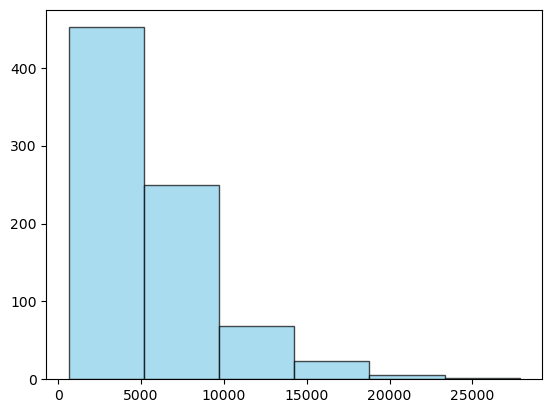

In [73]:
# How many bins should we have and what should they be? A histogram shows bucketing at the 5k marks could be effective.
# Lots of sales at the below 5k so we will split that bin in two at 2.5k
counts, bins, patches = plt.hist(
    hh_demographic_with_transaction_sums['total_sales'],
    bins=6,  # Number of bins
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)

In [75]:
# Define the bins and their corresponding labels
bin_edges = [0, 2500, 5000, 10000, 15000, 20000, float('inf')]
bin_labels = ['0-2.5k', '2.5k-5k', '5k-10k', '10k-15k', '15k-20k', '+20k']

sales_bin = []

# Loop through each value in 'total_sales' and assign a bin
for value in hh_demographic_with_transaction_sums['total_sales']:
    for i in range(len(bin_edges) - 1):
        if bin_edges[i] <= value < bin_edges[i + 1]:
            sales_bin.append(bin_labels[i])
            break

hh_demographic_with_transaction_sums['total_sales_range'] = sales_bin

# Define the desired order for the bins
bin_order = ['0-2.5k', '2.5k-5k', '5k-10k', '10k-15k', '15k-20k', '+20k']

# Convert the 'sales_bin' column to a categorical type with the specified order
hh_demographic_with_transaction_sums['total_sales_range'] = pd.Categorical(
    hh_demographic_with_transaction_sums['total_sales_range'],
    categories=bin_order,
    ordered=True
)

# Verify the order
print(hh_demographic_with_transaction_sums['total_sales_range'].value_counts().sort_index())

total_sales_range
0-2.5k     138
2.5k-5k    296
5k-10k     271
10k-15k     74
15k-20k     18
+20k         4
Name: count, dtype: int64


In [77]:
# Define the desired order for the bins
bin_order = ['0-2.5k', '2.5k-5k', '5k-10k', '10k-15k', '15k-20k', '+20k']

# Convert the 'sales_bin' column to a categorical type with the specified order
hh_demographic_with_transaction_sums['total_sales_range'] = pd.Categorical(
    hh_demographic_with_transaction_sums['total_sales_range'],
    categories=bin_order,
    ordered=True
)

# Verify the order
print(hh_demographic_with_transaction_sums['total_sales_range'].value_counts().sort_index())


total_sales_range
0-2.5k     138
2.5k-5k    296
5k-10k     271
10k-15k     74
15k-20k     18
+20k         4
Name: count, dtype: int64


# Heatmap of Spending an Demographic Columns

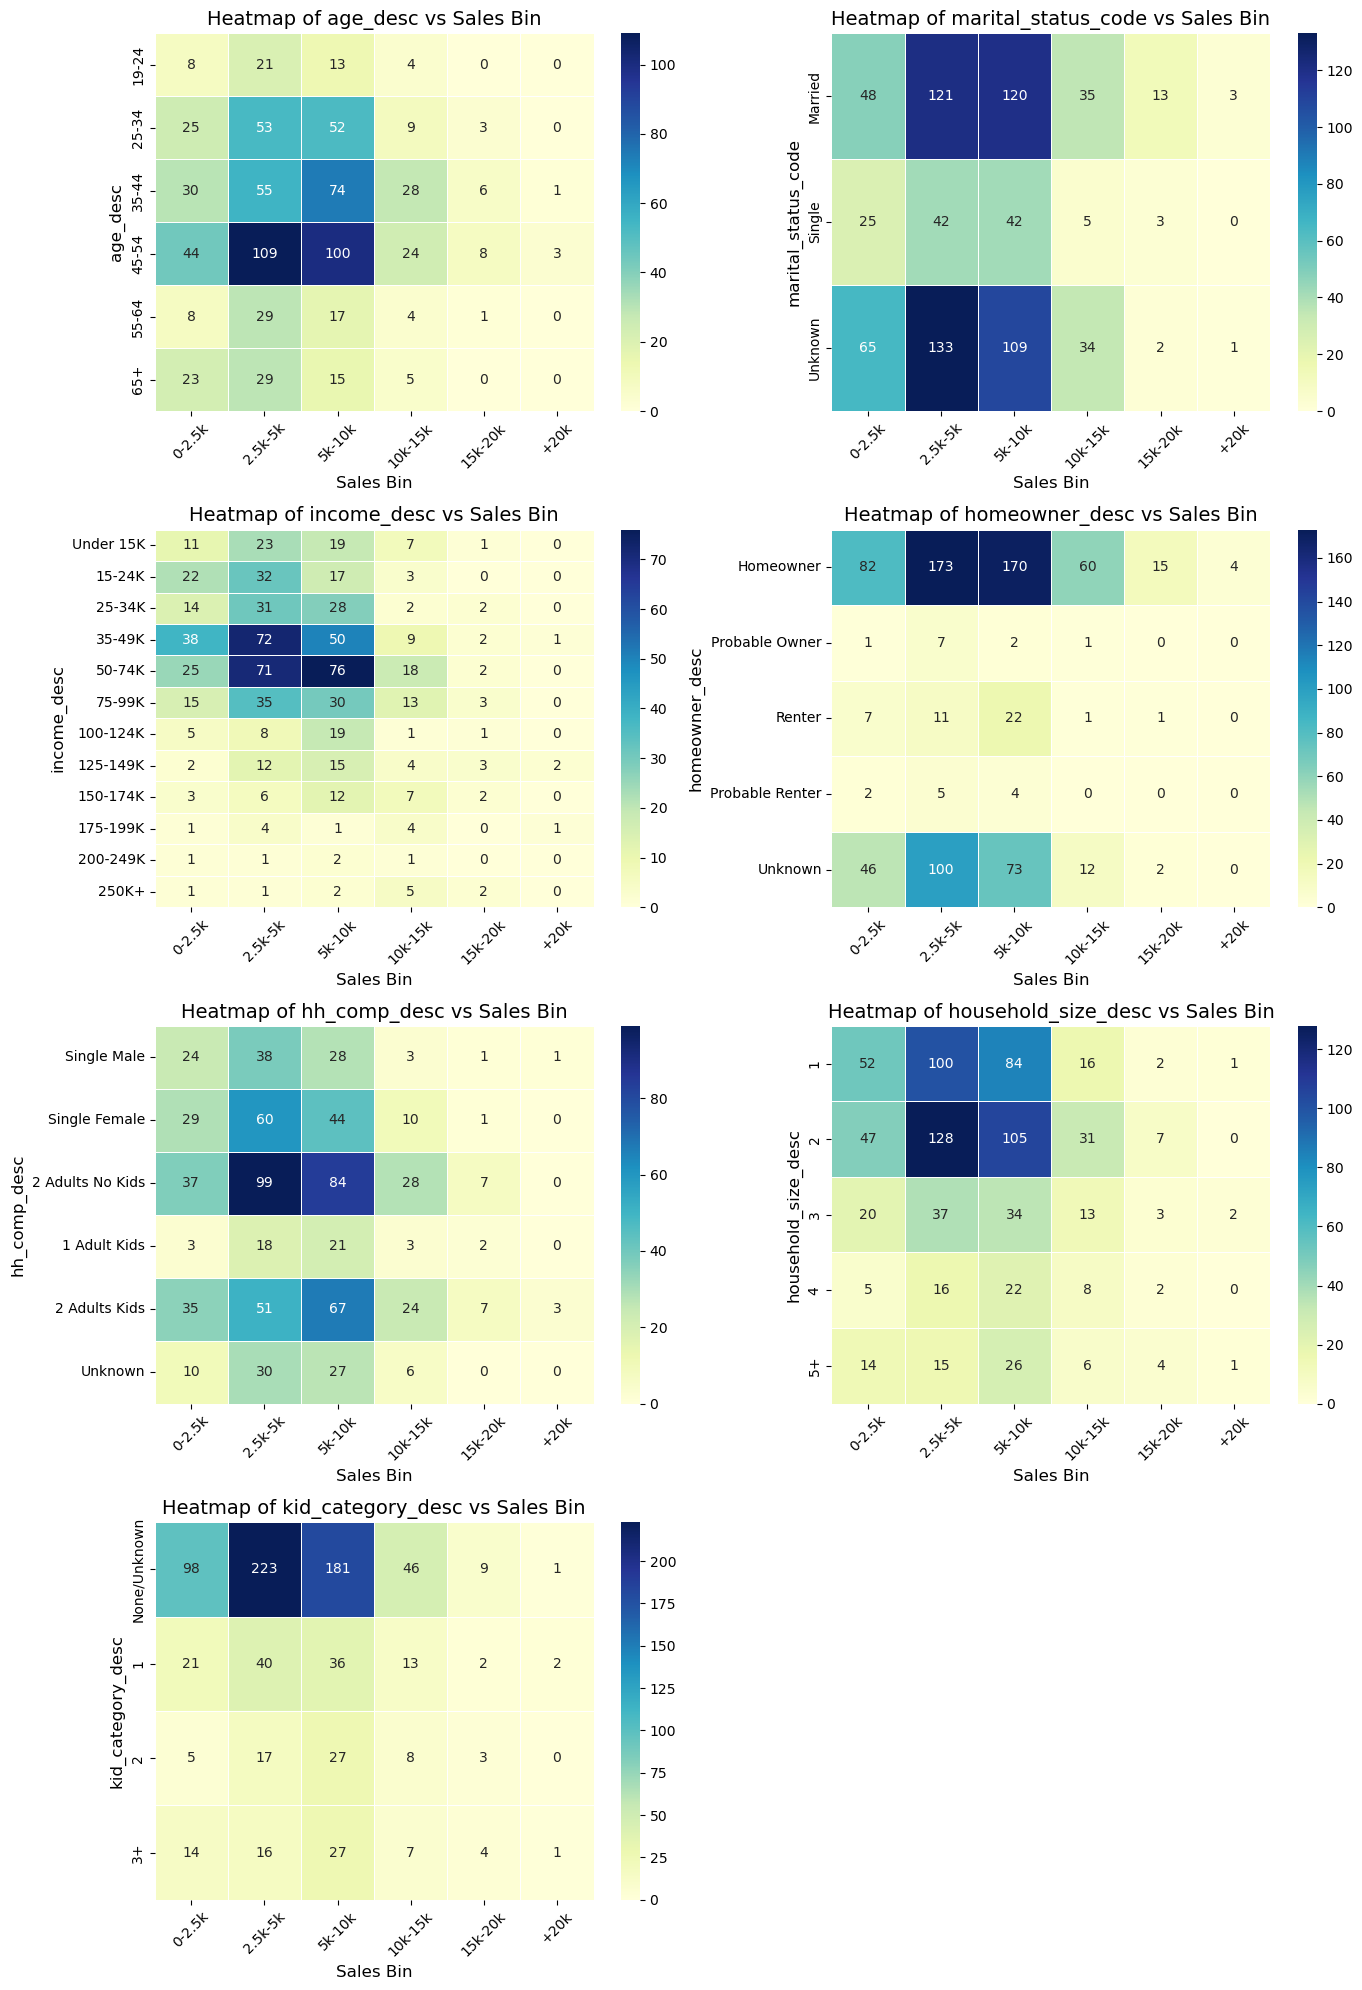

In [80]:
# List of demographic columns to compare
demographic_cols = ['age_desc', 'marital_status_code', 'income_desc', 
                    'homeowner_desc', 'hh_comp_desc', 'household_size_desc', 'kid_category_desc']

# Define the number of columns for the grid
num_columns = 2
num_rows = len(demographic_cols) // num_columns + (1 if len(demographic_cols) % num_columns != 0 else 0)

# Create a grid layout for the heatmaps
fig, axes = plt.subplots(num_rows, num_columns, figsize=(14, num_rows * 5))
axes = axes.flatten()  # Flatten the grid for easier indexing

# Loop through each demographic column
for i, col in enumerate(demographic_cols):
    # Create a pivot table for the heatmap
    pivot_table = hh_demographic_with_transaction_sums.pivot_table(
        index=col, 
        columns='total_sales_range', 
        values='household_key', 
        aggfunc='count', 
        fill_value=0,
        observed=False
    )
    
    # Plot the heatmap on the corresponding subplot
    sns.heatmap(
        pivot_table,
        annot=True,
        fmt='d',
        cmap=sns.color_palette("YlGnBu", as_cmap=True),
        linewidths=0.5,
        ax=axes[i]
    )
    axes[i].set_title(f"Heatmap of {col} vs Sales Bin", fontsize=14)
    axes[i].set_xlabel("Sales Bin", fontsize=12)
    axes[i].set_ylabel(col, fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].tick_params(axis='y')

# Remove any unused subplots
for j in range(len(demographic_cols), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


# Observations: Total Sales & Demographics

### Age Group Insights:

For the age range of 19-24, most households fall into the 2.5k-5k or 5k-10k sales bins.
As age increases, the number of households tends to shift more toward higher sales ranges, with a significant portion in the 2.5k-5k and 5k-10k bins.

### Marital Status Insights:

Married households dominate the higher sales bins (e.g., 5k-10k and 2.5k-5k).
Single households are more common in lower sales bins.
There is a large population in the 'Unknown' marital status. They resembele those in the married status more then the single status. 

### Income Insights:

Households with income Under 15K are predominantly in the lower sales bins (0-2.5k and 2.5k-5k).
Higher income groups, like 250K+, are sparse but spread across various sales ranges.

### Homeowner Insights:

Homeowners have a higher concentration in the middle sales bins (2.5k-5k and 5k-10k), while renters are a much smaller group.
There is a large population in the 'Unknown' homeowner statuss. They resembele those in the homeowner status although difficult to say with such a small number of renters

### Household Composition Insights:

Larger households (e.g., 2 Adults Kids) have a higher count in the 5k-10k sales range, while smaller households tend to have more varied distributions.

### Kid Category Insights:

Households without kids (None/Unknown) are more spread out, with many in the 2.5k-5k and 5k-10k bins. Families with kids (1, 2, or 3+ kids) are mostly in the lower bins but are also present in the 5k-10k range.

# Who are the customers?

This sample of 811 customers provides valuable insights into certain trends; however, it represents only a fraction of the full customer base. To gain a more comprehensive understanding, let's delve deeper by categorizing customers using RFM (Recency, Frequency, Monetary) segmentation.

# RFM Kmeans 

In [85]:
# Individual basket_id's are trips to the store. Lets group by household_key and count the basket_id 

transactions_groupby_basket = transaction_data.groupby('basket_id').agg(

    total_sales=('sales_value', 'sum'),
    household_key=('household_key','max'),
    day=('day','max')   
)

In [87]:
transactions_groupby_basket['total_sales'].value_counts().head(20)

total_sales
1.00     2726
10.00    2345
20.00    2124
2.00     1702
5.00     1156
0.99     1155
2.99     1135
3.99     1133
4.99     1045
1.99     1036
15.00    1012
1.29      954
3.00      944
0.00      942
4.00      809
5.99      784
2.50      764
6.99      682
7.99      671
1.50      657
Name: count, dtype: int64

In [89]:
# A number of transictions have $0. lets remove these
transactions_groupby_basket = transactions_groupby_basket[transactions_groupby_basket['total_sales'] != 0.00]

In [91]:
transactions_groupby_basket.head()

total_sales  household_key  day
basket_id                                   
26984851472         5.91           2375    1
26984851516        12.43           2375    1
26984896261        11.37           1364    1
26984905972         2.55           1130    1
26984945254         3.53           1173    1

In [93]:
# Make a rfm df
rfm=transactions_groupby_basket.groupby('household_key').agg(
    total_trips=('household_key','count'),
    total_sales=('total_sales', 'sum'),
    last_trip_day=('day','max')   
)

In [95]:
rfm.head()

total_trips  total_sales  last_trip_day
household_key                                         
1                       85      4330.16            706
2                       45      1954.34            668
3                       47      2653.21            703
4                       30      1200.11            627
5                       40       779.06            703

In [97]:
# Add in recency column

rfm['recency']=711-rfm['last_trip_day']

rfm = rfm.drop(['last_trip_day'], axis=1)

rfm.rename(columns={
    'total_trips': 'frequency',
    'total_sales': 'monetary'}, inplace=True)
rfm.head()


frequency  monetary  recency
household_key                              
1                     85   4330.16        5
2                     45   1954.34       43
3                     47   2653.21        8
4                     30   1200.11       84
5                     40    779.06        8

# Histograms & Boxplot of rfm

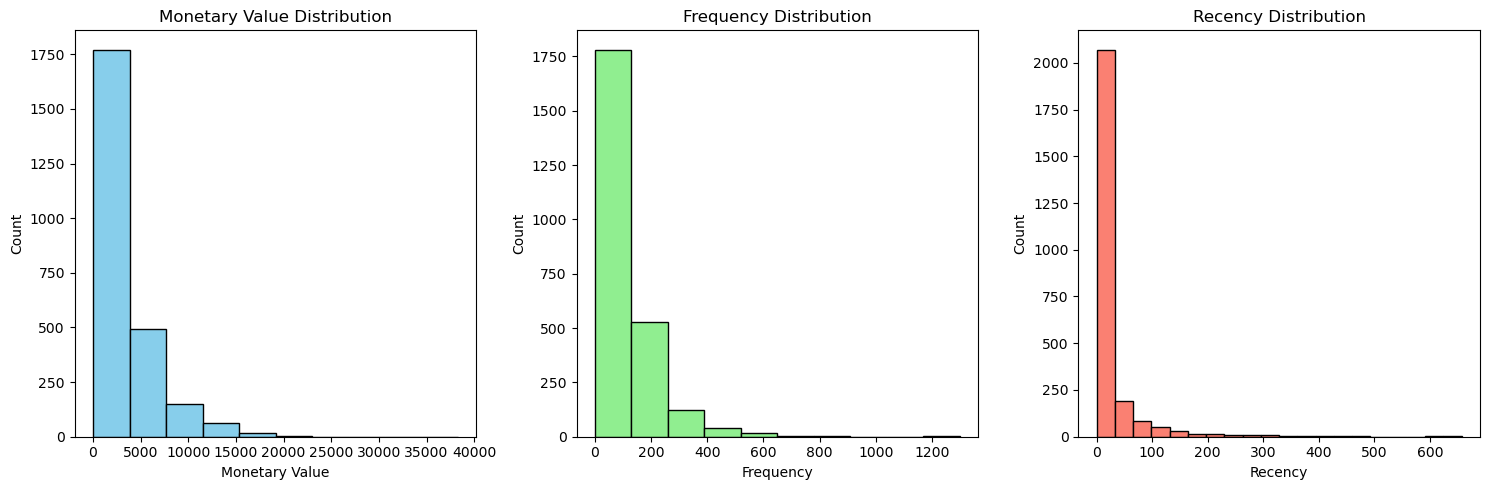

In [100]:
plt.figure(figsize=(15, 5))

# Monetary Value Distribution
plt.subplot(1, 3, 1)
plt.hist(rfm['monetary'], bins=10, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

# Frequency Distribution
plt.subplot(1, 3, 2)
plt.hist(rfm['frequency'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

# Recency Distribution
plt.subplot(1, 3, 3)
plt.hist(rfm['recency'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

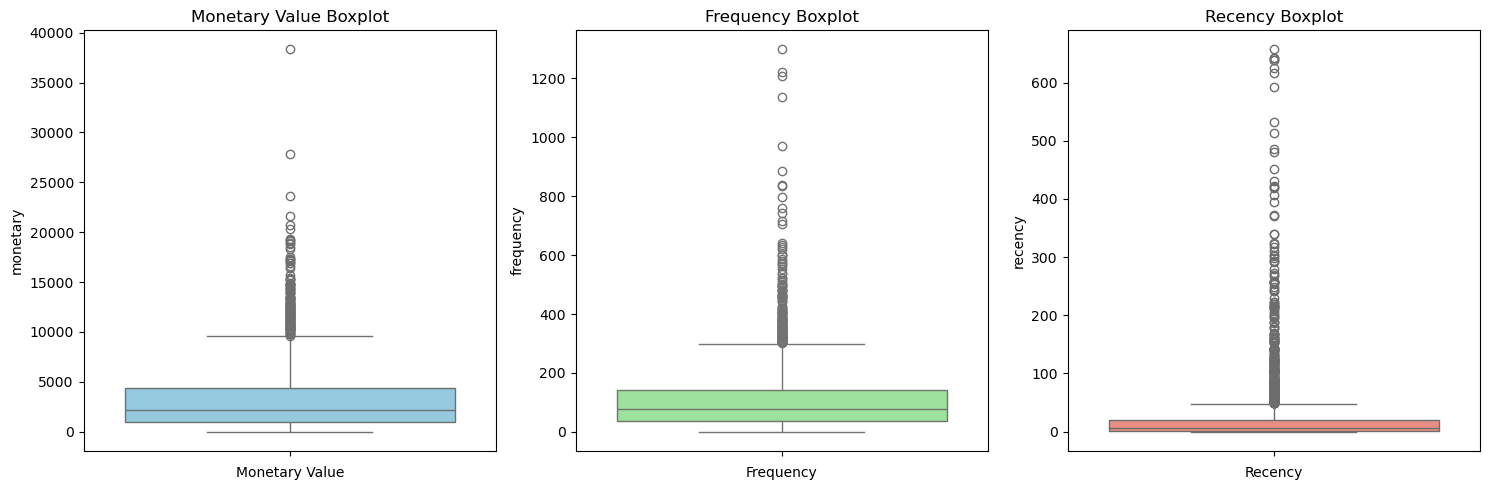

In [102]:
plt.figure(figsize=(15, 5))

# Monetary Value Boxplot
plt.subplot(1, 3, 1)
sns.boxplot(data=rfm['monetary'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

# Frequency Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(data=rfm['frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

# Recency Boxplot
plt.subplot(1, 3, 3)
sns.boxplot(data=rfm['recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()


### Outliers in All Three Categories
There are significant outliers present in all three categories. To improve the effectiveness of our KMeans clustering, it is essential to separate these outliers for more accurate and meaningful results.

In [105]:
# Calculate IQR and outliers for Recency
R_Q1 = rfm['recency'].quantile(0.25)
R_Q3 = rfm['recency'].quantile(0.75)
R_IQR = R_Q3 - R_Q1

recency_outliers_df = rfm[(rfm['recency'] > (R_Q3 + 1.5 * R_IQR)) | (rfm['recency'] < (R_Q1 - 1.5 * R_IQR))].copy()
###########################################

# Calculate IQR and outliers for Frequency
F_Q1 = rfm['frequency'].quantile(0.25)
F_Q3 = rfm['frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1

frequency_outliers_df = rfm[(rfm['frequency'] > (F_Q3 + 1.5 * F_IQR)) | (rfm['frequency'] < (F_Q1 - 1.5 * F_IQR))].copy()
###########################################

# Calculate IQR and outliers for Monetary
M_Q1 = rfm['monetary'].quantile(0.25)
M_Q3 = rfm['monetary'].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers_df = rfm[(rfm['monetary'] > (M_Q3 + 1.5 * M_IQR)) | (rfm['monetary'] < (M_Q1 - 1.5 * M_IQR))].copy()
###########################################

# Combine all outliers
outliers_df = pd.concat([monetary_outliers_df, frequency_outliers_df, recency_outliers_df]).drop_duplicates()
###########################################

# Create a non-outliers DataFrame
non_outliers_df = rfm[~rfm.index.isin(outliers_df.index)]

# Display descriptions of the DataFrames
print("Monetary Outliers Description:")
print(monetary_outliers_df.describe())
print("\nFrequency Outliers Description:")
print(frequency_outliers_df.describe())
print("\nRecency Outliers Description:")
print(recency_outliers_df.describe())
print("\nNon-Outliers DataFrame Description:")
print(non_outliers_df.describe())


Monetary Outliers Description:
         frequency      monetary     recency
count   127.000000    127.000000  127.000000
mean    346.110236  13518.659685    3.346457
std     221.701402   3828.094351   10.126484
min      69.000000   9618.900000    0.000000
25%     216.000000  11206.085000    0.000000
50%     310.000000  12470.030000    1.000000
75%     386.000000  14682.065000    3.000000
max    1298.000000  38319.790000   89.000000

Frequency Outliers Description:
         frequency      monetary     recency
count   147.000000    147.000000  147.000000
mean    449.346939  10101.306939    2.802721
std     183.222324   5390.437743    8.692336
min     302.000000   1315.440000    0.000000
25%     337.000000   6277.265000    0.000000
50%     382.000000   9204.220000    1.000000
75%     488.000000  12712.455000    2.000000
max    1298.000000  38319.790000   89.000000

Recency Outliers Description:
        frequency      monetary     recency
count  326.000000    326.000000  326.000000
mean   

### Boxplot with non-outliers

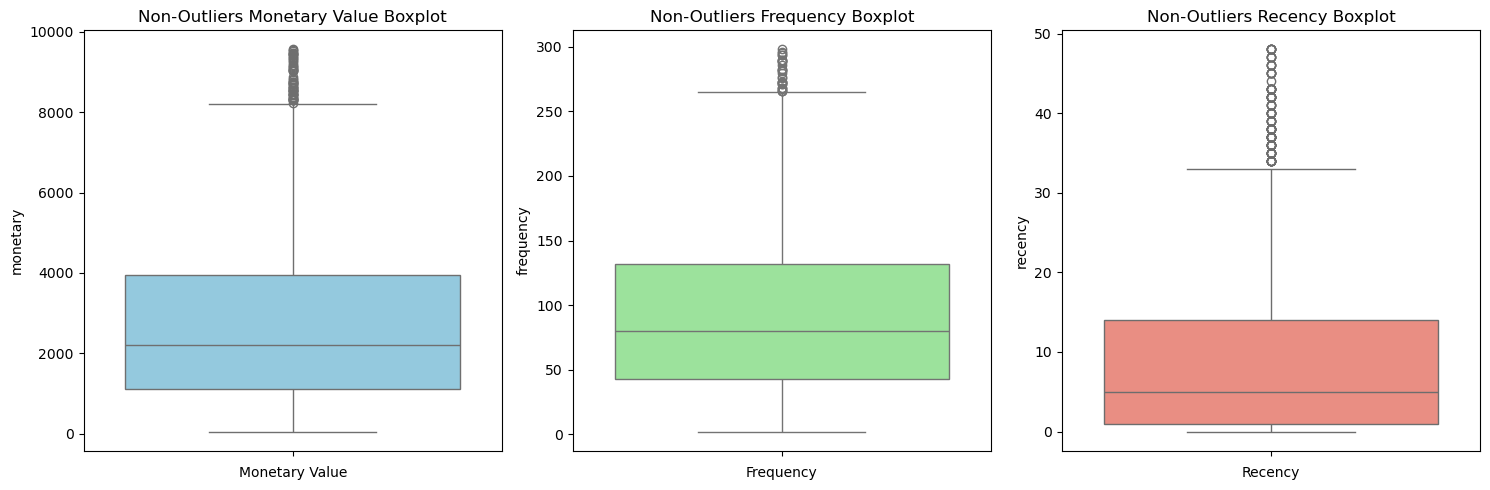

In [108]:
plt.figure(figsize=(15, 5))

# Monetary Value Boxplot
plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers_df['monetary'], color='skyblue')
plt.title('Non-Outliers Monetary Value Boxplot')
plt.xlabel('Monetary Value')

# Frequency Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers_df['frequency'], color='lightgreen')
plt.title('Non-Outliers Frequency Boxplot')
plt.xlabel('Frequency')

# Recency Boxplot
plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers_df['recency'], color='salmon')
plt.title('Non-Outliers Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()


### Visualizing RFM in 3D
Let's create a 3D visualization of the RFM (Recency, Frequency, Monetary) data to better understand the relationships and patterns between these variables.

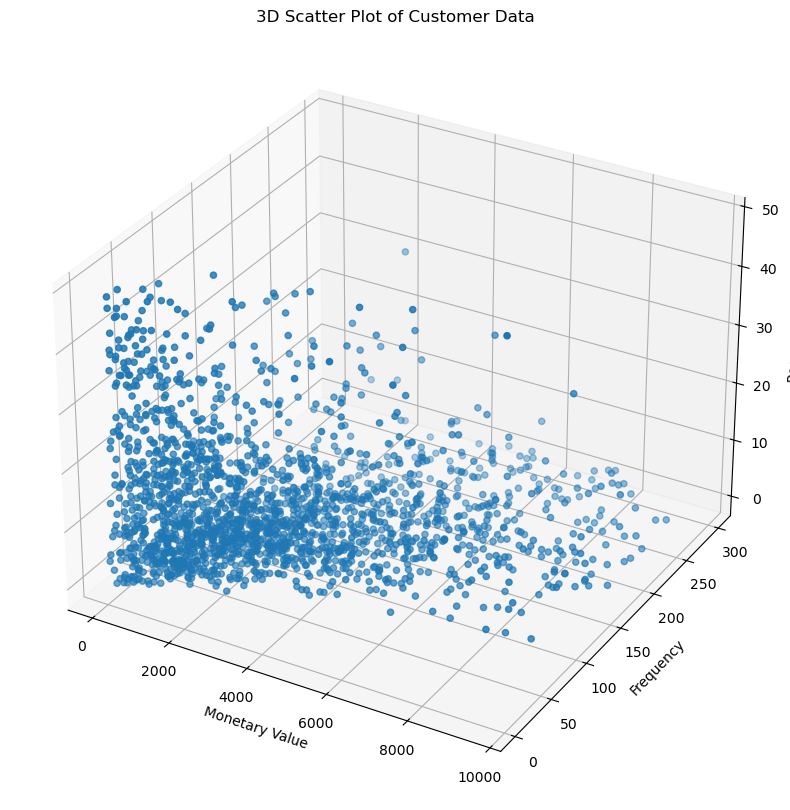

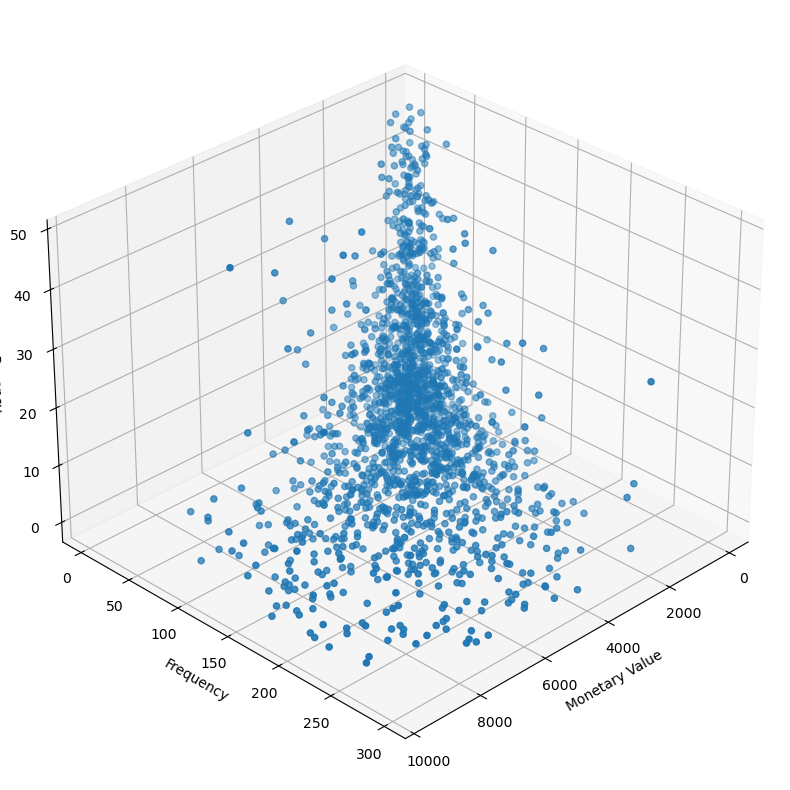

In [111]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df["monetary"], non_outliers_df["frequency"], non_outliers_df["recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

# Adjusting the view angle to make labels more readable
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df["monetary"], non_outliers_df["frequency"], non_outliers_df["recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.view_init(elev=30, azim=45)

plt.show()



### Data Scaling Required for RFM

It's important to note that the scales of Recency, Frequency, and Monetary values differ significantly, ranging from tens, hundreds, to thousands. To ensure effective clustering with KMeans, we need to scale the data before running the algorithm.

In [114]:
scaler = StandardScaler()

# Scale the monetary, frequency, and recency columns from the non-outliers DataFrame
scaled_data_non_outliers = scaler.fit_transform(non_outliers_df[["monetary", "frequency", "recency"]])
scaled_data_non_outliers

array([[ 0.72059065, -0.14002934, -0.39303855],
       [-0.38592019, -0.77006532,  3.19935876],
       [-0.06042952, -0.73856352, -0.10942823],
       ...,
       [-0.08446629,  1.23029893, -0.77118563],
       [ 0.2846175 , -0.06127484, -0.67664886],
       [ 1.25898435,  0.30099585, -0.58211209]])

In [116]:
# Create a DataFrame from the scaled data with the original index and updated column names
scaled_data_non_outliers_df = pd.DataFrame(scaled_data_non_outliers, index=non_outliers_df.index, columns=["monetary", "frequency", "recency"])

scaled_data_non_outliers_df.head()

monetary  frequency   recency
household_key                               
1              0.720591  -0.140029 -0.393039
2             -0.385920  -0.770065  3.199359
3             -0.060430  -0.738564 -0.109428
5             -0.933293  -0.848820 -0.109428
6              1.496511   2.443118 -0.487575

### Visualizing RFM in 3D- Now with scaled data

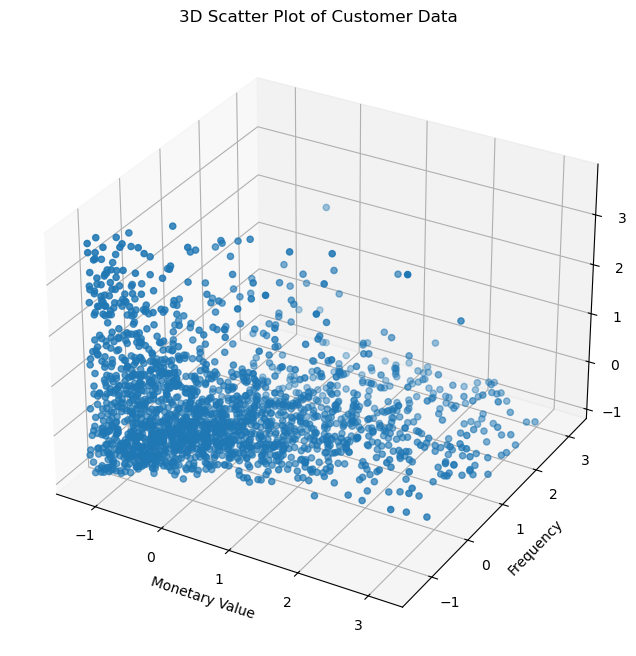

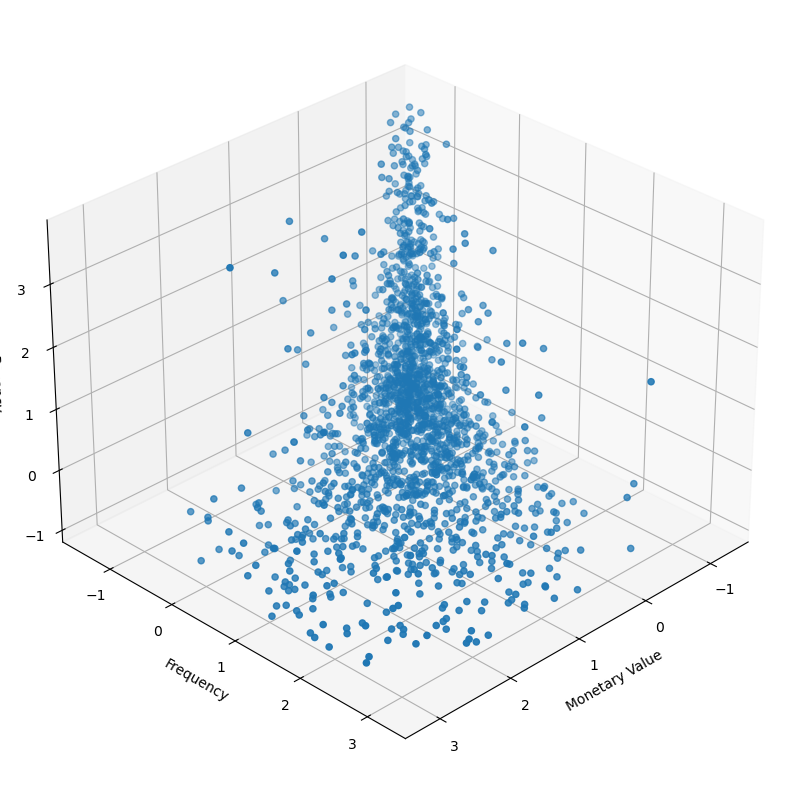

In [119]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data_non_outliers_df["monetary"], scaled_data_non_outliers_df["frequency"], scaled_data_non_outliers_df["recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()


# Adjusting the view angle to make labels more readable
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data_non_outliers_df["monetary"], scaled_data_non_outliers_df["frequency"], scaled_data_non_outliers_df["recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.view_init(elev=30, azim=45)

plt.show()

# Evaluating KMeans Clustering: Inertia and Silhouette Scores for Varying k

Inertia: Measures how tightly data points are clustered around their centroids; lower values are better.

Silhouette Score: Assesses how well each point fits its cluster, with values closer to 1 indicating better clustering.

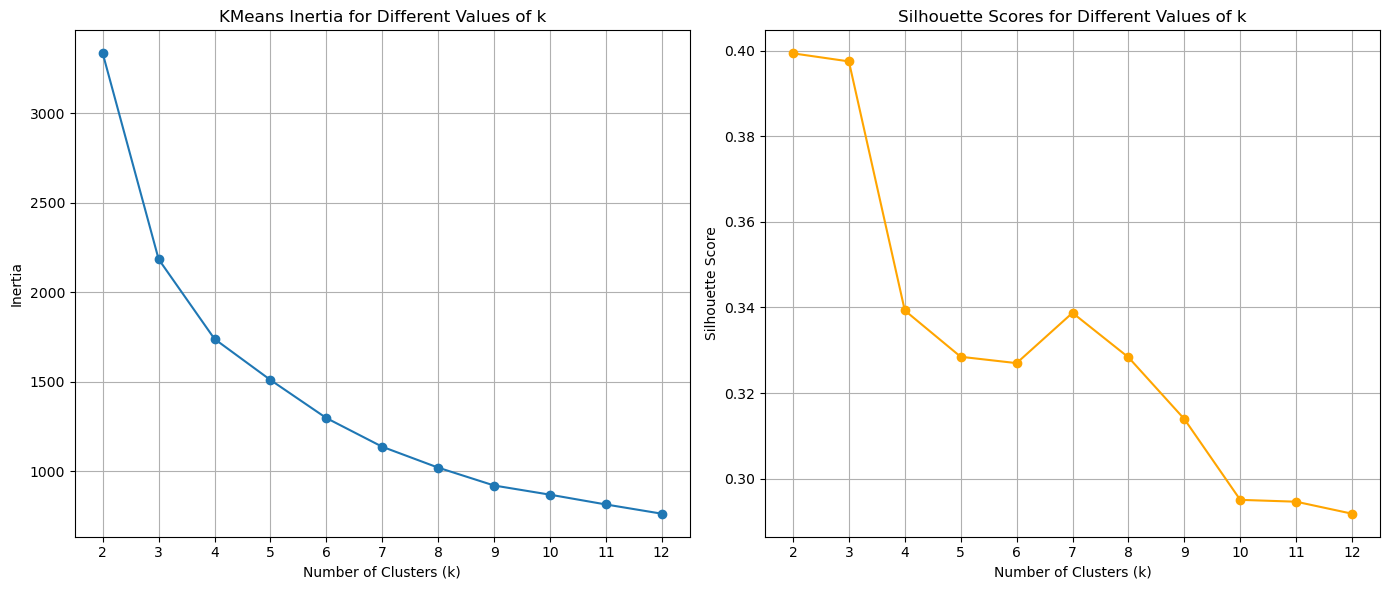

In [122]:
# Set the range of k values to try (2 to 12 clusters)
max_k = 12

inertia = []
silhouette_scores = []
k_values = range(2, max_k + 1)

# Loop through different values of k to calculate inertia and silhouette scores
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=25, max_iter=1000)

    # Perform KMeans clustering on the scaled data
    cluster_labels = kmeans.fit_predict(scaled_data_non_outliers_df)

    # Calculate the silhouette score for the clustering
    sil_score = silhouette_score(scaled_data_non_outliers_df, cluster_labels)

    silhouette_scores.append(sil_score)
    inertia.append(kmeans.inertia_)

# Plot the inertia and silhouette scores for different values of k
plt.figure(figsize=(14, 6))

# Inertia plot
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

# Silhouette scores plot
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

# Adjust layout and display plots
plt.tight_layout()
plt.show()


We will select 4 clusters, as it offers a good balance between inertia and silhouette score. This choice allows for more tailored analysis, helping to better group customers for targeted insights.

In [125]:
kmeans = KMeans(n_clusters=4, random_state=25, max_iter=1000)

cluster_labels = kmeans.fit_predict(scaled_data_non_outliers_df)

cluster_labels

array([3, 0, 2, ..., 3, 3, 3])

In [127]:
scaled_data_non_outliers_df["cluster"] = cluster_labels

scaled_data_non_outliers_df.head()

monetary  frequency   recency  cluster
household_key                                        
1              0.720591  -0.140029 -0.393039        3
2             -0.385920  -0.770065  3.199359        0
3             -0.060430  -0.738564 -0.109428        2
5             -0.933293  -0.848820 -0.109428        2
6              1.496511   2.443118 -0.487575        1

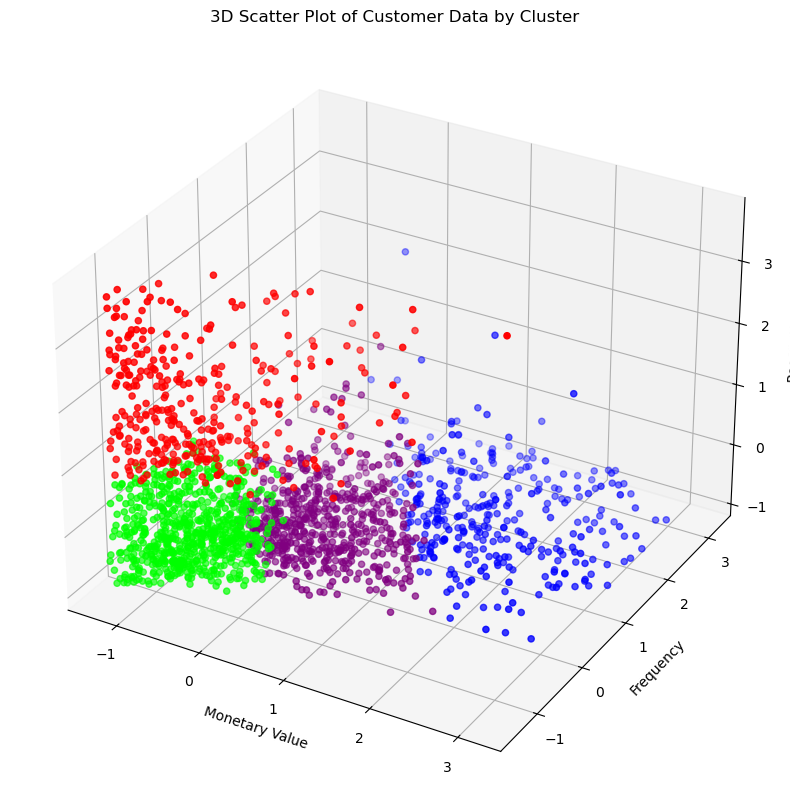

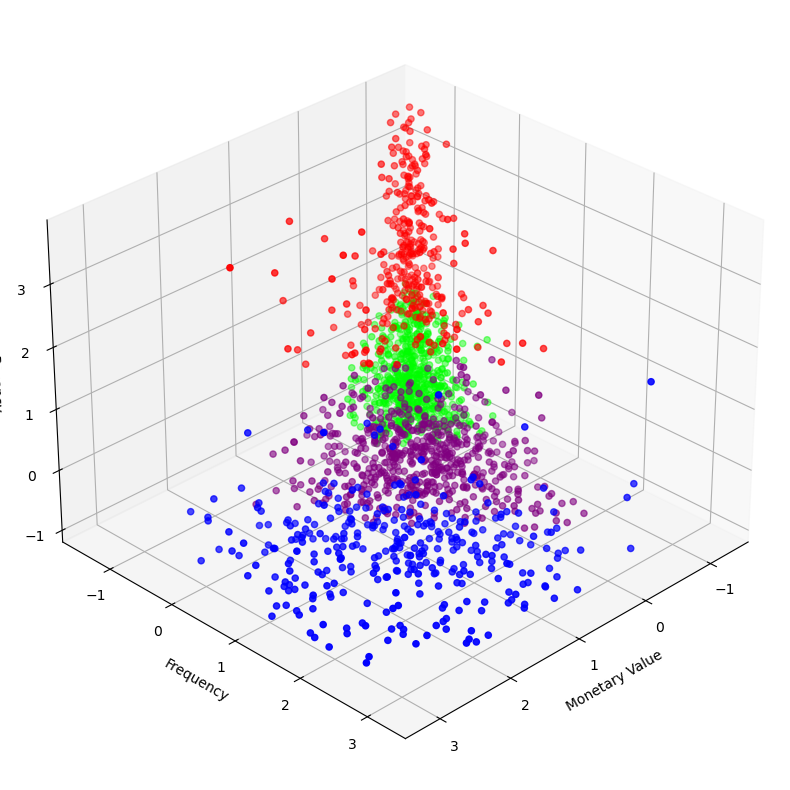

In [129]:
cluster_colors = {0: '#FF0000',  # Red
                  1: '#0000FF',  # Blue
                  2: '#00FF00',  # Green
                  3: '#800080'   # Purple
                 }

# Map the cluster labels from scaled_data_non_outliers_df to colors
colors = scaled_data_non_outliers_df['cluster'].map(cluster_colors)

# Create the 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# Scatter plot with the colors mapped based on the cluster
scatter = ax.scatter(scaled_data_non_outliers_df['monetary'], 
                     scaled_data_non_outliers_df['frequency'], 
                     scaled_data_non_outliers_df['recency'], 
                     c=colors,  # Use mapped solid colors
                     marker='o')

# Set labels and title
ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()

# Adjusting the view angle to make labels more readable
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data_non_outliers_df["monetary"],
                     scaled_data_non_outliers_df["frequency"],
                     scaled_data_non_outliers_df["recency"], 
                     c=colors,  # Use mapped solid colors
                     marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.view_init(elev=30, azim=45)

plt.show()

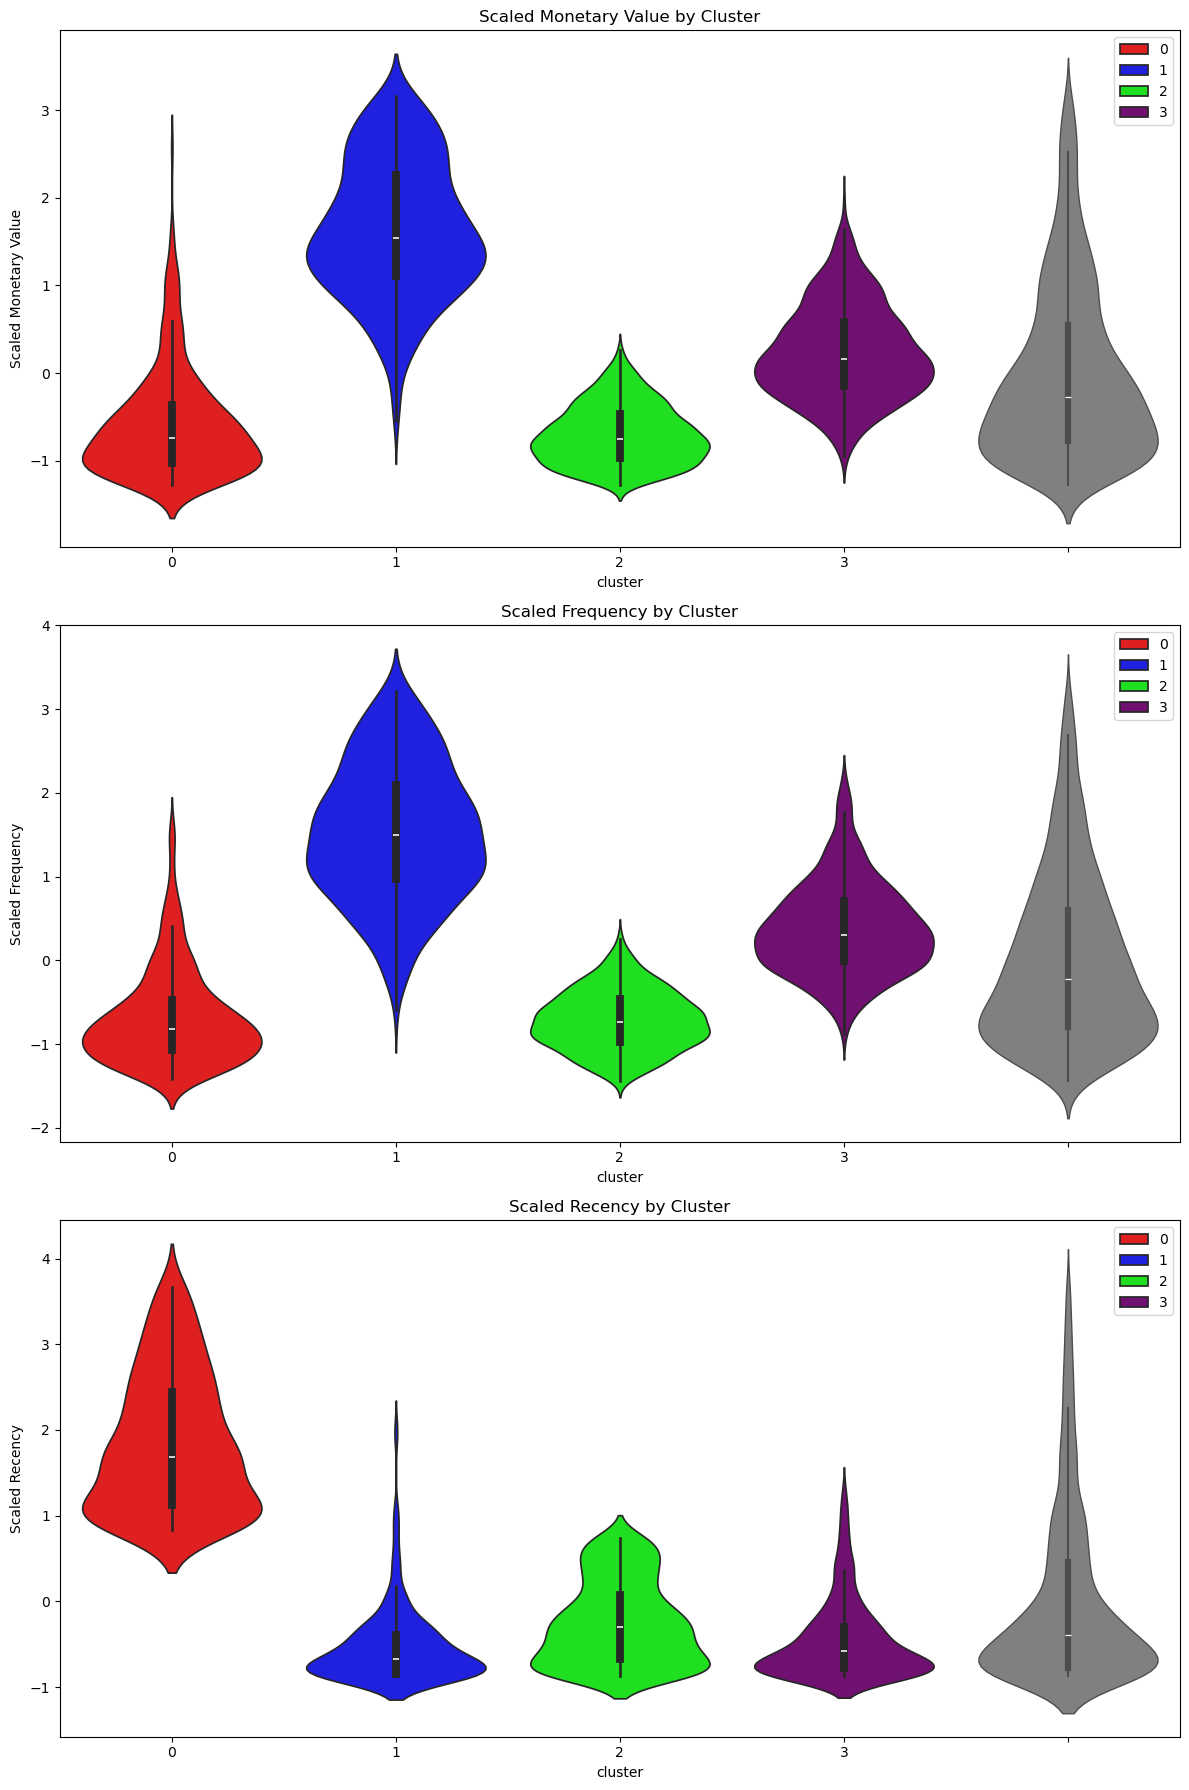

In [131]:
plt.figure(figsize=(12, 18))

# Violin plot for Scaled Monetary Value by Cluster
plt.subplot(3, 1, 1)
sns.violinplot(x=scaled_data_non_outliers_df['cluster'], y=scaled_data_non_outliers_df['monetary'], palette=cluster_colors, hue=scaled_data_non_outliers_df["cluster"])
sns.violinplot(y=scaled_data_non_outliers_df['monetary'], color='gray', linewidth=1.0)
plt.title('Scaled Monetary Value by Cluster')
plt.ylabel('Scaled Monetary Value')

# Violin plot for Scaled Frequency by Cluster
plt.subplot(3, 1, 2)
sns.violinplot(x=scaled_data_non_outliers_df['cluster'], y=scaled_data_non_outliers_df['frequency'], palette=cluster_colors, hue=scaled_data_non_outliers_df["cluster"])
sns.violinplot(y=scaled_data_non_outliers_df['frequency'], color='gray', linewidth=1.0)
plt.title('Scaled Frequency by Cluster')
plt.ylabel('Scaled Frequency')

# Violin plot for Scaled Recency by Cluster
plt.subplot(3, 1, 3)
sns.violinplot(x=scaled_data_non_outliers_df['cluster'], y=scaled_data_non_outliers_df['recency'], palette=cluster_colors, hue=scaled_data_non_outliers_df["cluster"])
sns.violinplot(y=scaled_data_non_outliers_df['recency'], color='gray', linewidth=1.0)
plt.title('Scaled Recency by Cluster')
plt.ylabel('Scaled Recency')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# Lets define these customers

Cluster 0: This cluster represents low-priority or inactive customers. They neither spend much nor shop frequently and haven’t engaged with the store recently.

Cluster 1: This cluster is the most valuable. These are high-value, loyal customers who spend and shop frequently. They are engaged and should be prioritized for retention strategies.

Cluster 2: This cluster includes occasional, low-spending shoppers who have shown some recent engagement. They could be potential candidates for targeted promotions to boost frequency and spending.

Cluster 3: This cluster consists of relatively active shoppers who shop fairly frequently and spend a moderate amount. They are recent shoppers, likely valuable for maintaining store engagement. We want to encourage these customers to become like those in cluster 1

## Now lets work with the outlyers

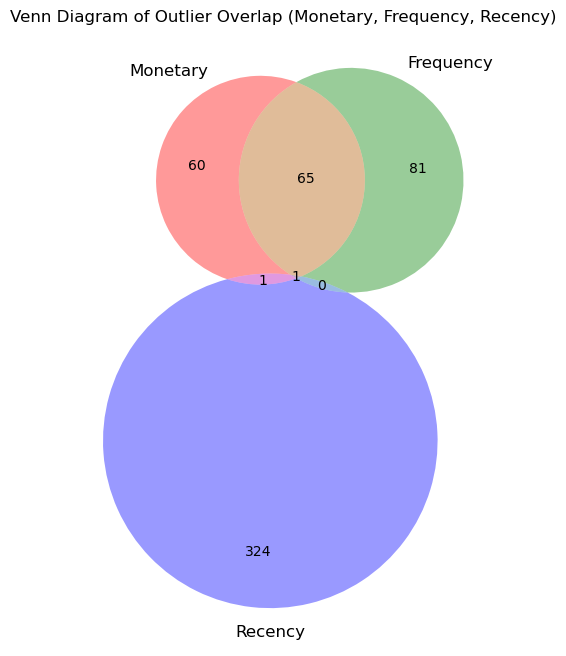

In [136]:
# Find the indices of the outliers for each category
monetary_outlier_indices = set(monetary_outliers_df.index)
frequency_outlier_indices = set(frequency_outliers_df.index)
recency_outlier_indices = set(recency_outliers_df.index)

# Calculate the overlaps
overlap_monetary_frequency = monetary_outlier_indices.intersection(frequency_outlier_indices)
overlap_monetary_recency = monetary_outlier_indices.intersection(recency_outlier_indices)
overlap_frequency_recency = frequency_outlier_indices.intersection(recency_outlier_indices)
overlap_all_three = monetary_outlier_indices.intersection(frequency_outlier_indices, recency_outlier_indices)

# Calculate the sizes for each unique region of the Venn diagram
monetary_only = len(monetary_outlier_indices - frequency_outlier_indices - recency_outlier_indices)
frequency_only = len(frequency_outlier_indices - monetary_outlier_indices - recency_outlier_indices)
recency_only = len(recency_outlier_indices - monetary_outlier_indices - frequency_outlier_indices)
monetary_and_frequency = len(overlap_monetary_frequency - recency_outlier_indices)
monetary_and_recency = len(overlap_monetary_recency - frequency_outlier_indices)
frequency_and_recency = len(overlap_frequency_recency - monetary_outlier_indices)
all_three = len(overlap_all_three)

# Plot the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn3(
    subsets=(
        monetary_only,          # Monetary only
        frequency_only,         # Frequency only
        monetary_and_frequency, # Monetary & Frequency
        recency_only,           # Recency only
        monetary_and_recency,   # Monetary & Recency
        frequency_and_recency,  # Frequency & Recency
        all_three               # All three
    ),
    set_labels=('Monetary', 'Frequency', 'Recency')
)

# Add title and labels
plt.title("Venn Diagram of Outlier Overlap (Monetary, Frequency, Recency)")
plt.show()


We observe that the monetary and frequency outliers overlap, while the other categories show little to no overlap. To address this, we can group the exclusive outliers based on monetary, frequency, and recency. 

Specifically, we will place the household that overlaps with both monetary and recency into the monetary group to target them with a promotion aimed at encouraging higher spending. Similarly, another group will be formed for those who overlap in both monetary and frequency, including the household that also overlaps with recency

In [139]:
# Find the overlaps between the categories
overlap_monetary_frequency = monetary_outlier_indices.intersection(frequency_outlier_indices)
overlap_monetary_recency = monetary_outlier_indices.intersection(recency_outlier_indices)
overlap_frequency_recency = frequency_outlier_indices.intersection(recency_outlier_indices)
overlap_all_three = monetary_outlier_indices.intersection(frequency_outlier_indices, recency_outlier_indices)

# 1. Monetary-only outliers (excluding overlap with Frequency and overlap_all_three but keeping overlap with Recency)
monetary_only_indices = list(monetary_outlier_indices - overlap_monetary_frequency - overlap_all_three)
monetary_only_outliers = monetary_outliers_df.loc[monetary_only_indices]
monetary_only_outliers["cluster"] = -1

# 2. Frequency-only outliers (excluding overlap with Recency and overlap_all_three but keeping overlap with Monetary)
frequency_only_indices = list(frequency_outlier_indices - overlap_monetary_frequency - overlap_all_three)
frequency_only_outliers = frequency_outliers_df.loc[frequency_only_indices]
frequency_only_outliers["cluster"] = -2

# 3. Recency-only outliers (excluding overlap with Monetary and Frequency)
recency_only_indices = list(recency_outlier_indices - overlap_monetary_recency - overlap_all_three)
recency_only_outliers = recency_outliers_df.loc[recency_only_indices]
recency_only_outliers["cluster"] = -3

# 4. Monetary and Frequency overlap (including Recency)
monetary_frequency_indices = list(overlap_monetary_frequency)
monetary_frequency_outliers = monetary_outliers_df.loc[monetary_frequency_indices]
monetary_frequency_outliers["cluster"] = -4

# Combine all outliers into a single DataFrame
outlier_clusters_df = pd.concat([
    monetary_only_outliers, 
    frequency_only_outliers, 
    recency_only_outliers, 
    monetary_frequency_outliers
])

outlier_clusters_df.head()


frequency  monetary  recency  cluster
household_key                                       
256                  124   9850.35        0       -1
513                  161  12130.01        6       -1
1029                 276  13785.55        3       -1
389                  268  14880.92        1       -1
392                  104  11443.97        2       -1

In [141]:
for cluster_id in outlier_clusters_df['cluster'].unique():
    cluster_data = outlier_clusters_df.loc[outlier_clusters_df['cluster'] == cluster_id]
    print(f"Cluster {cluster_id} Statistics:")
    print(cluster_data.describe())
    print("\n")



Cluster -1 Statistics:
        frequency      monetary    recency  cluster
count   61.000000     61.000000  61.000000     61.0
mean   202.409836  12388.179344   3.409836     -1.0
std     52.766586   1874.651447   7.800378      0.0
min     69.000000   9618.900000   0.000000     -1.0
25%    163.000000  11041.410000   0.000000     -1.0
50%    214.000000  11984.590000   2.000000     -1.0
75%    237.000000  13404.830000   3.000000     -1.0
max    288.000000  17332.130000  60.000000     -1.0


Cluster -2 Statistics:
        frequency     monetary    recency  cluster
count   81.000000    81.000000  81.000000     81.0
mean   425.246914  6465.447901   2.407407     -2.0
std    122.184034  2155.828592   4.655045      0.0
min    302.000000  1315.440000   0.000000     -2.0
25%    333.000000  5029.860000   0.000000     -2.0
50%    382.000000  6574.230000   1.000000     -2.0
75%    482.000000  8355.230000   2.000000     -2.0
max    886.000000  9500.700000  30.000000     -2.0


Cluster -3 Statistics:


## Violin Plots of the four outlier clusters

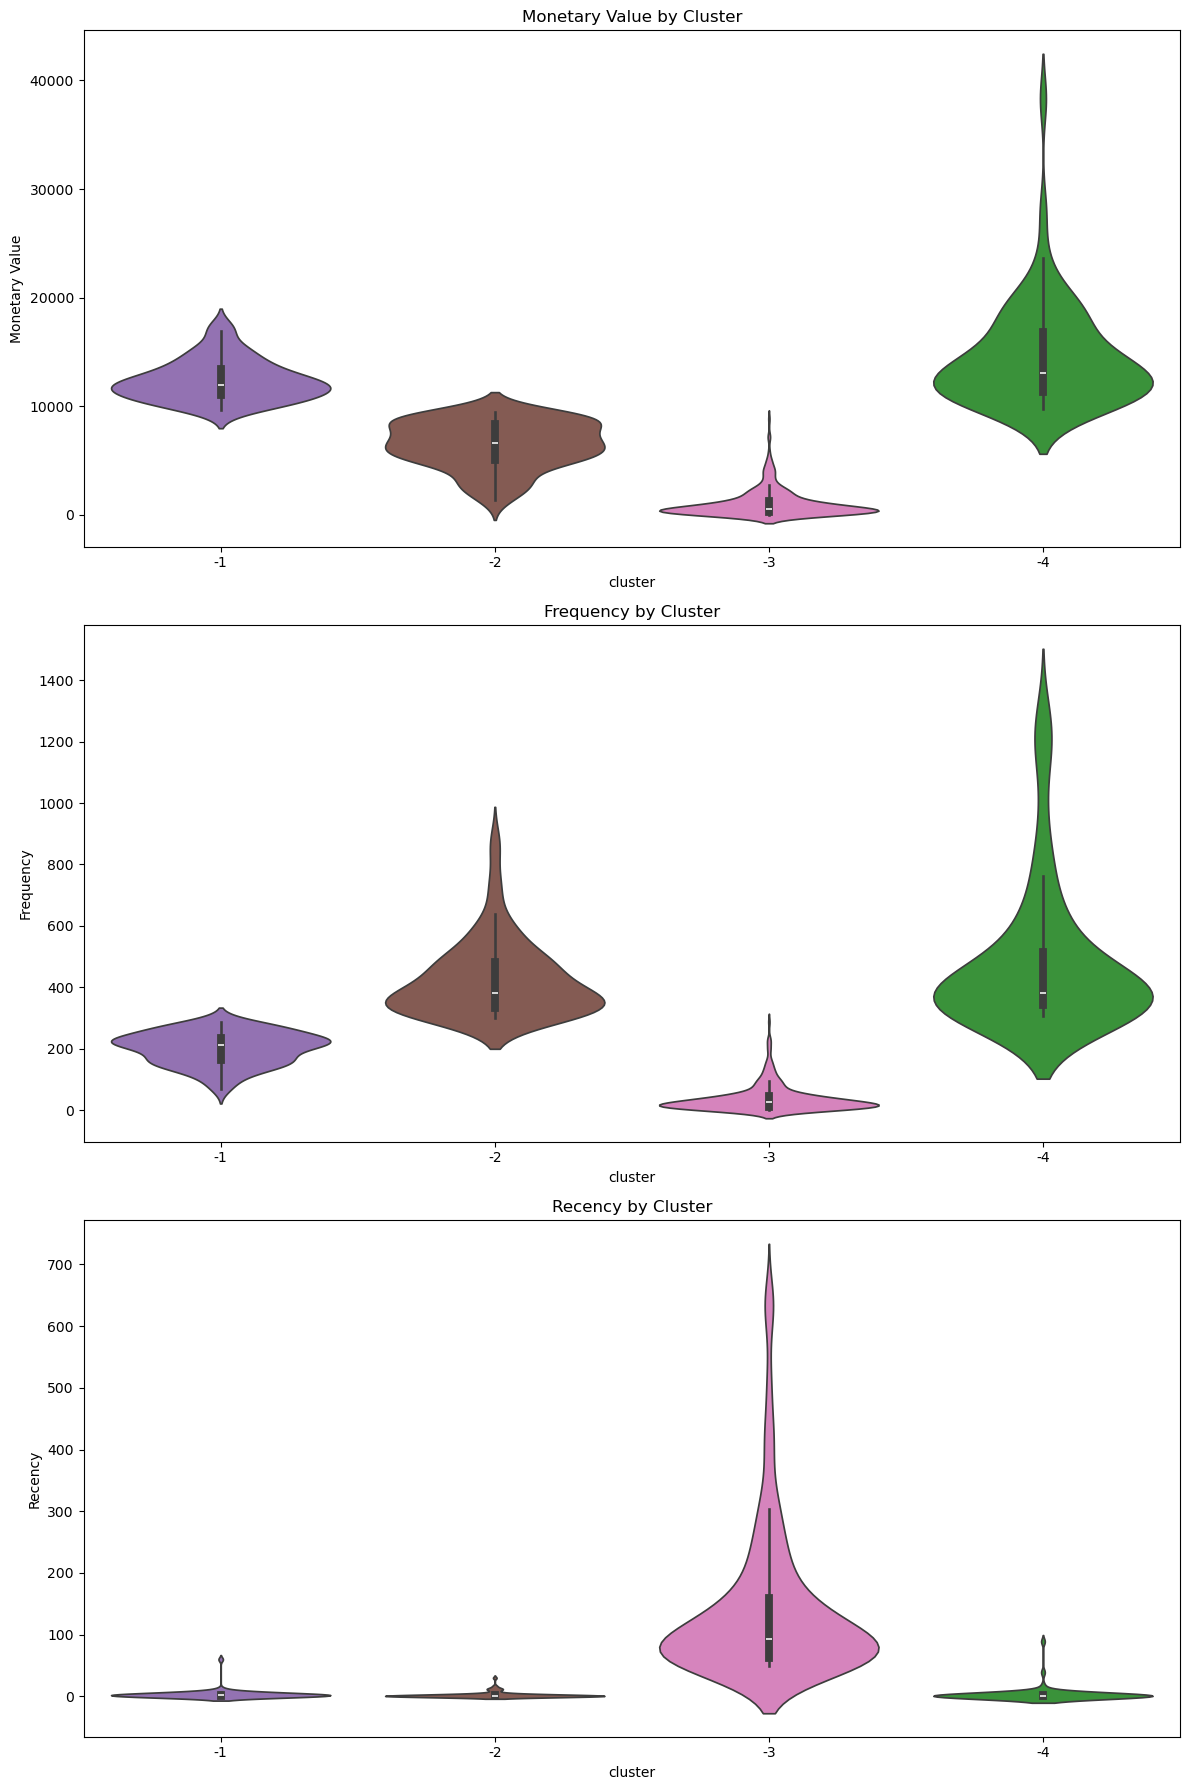

In [144]:
# Ensure cluster column values are strings (if needed for the palette)
outlier_clusters_df['cluster'] = outlier_clusters_df['cluster'].astype(str)

# Define cluster colors as strings to match the cluster column
cluster_colors = {
    "-1": '#9467bd',
    "-2": '#8c564b',
    "-3": '#e377c2',
    "-4": '#2ca02c'
}

plt.figure(figsize=(12, 18))

# Plot 1: Monetary Value by Cluster
plt.subplot(3, 1, 1)
sns.violinplot(
    x=outlier_clusters_df['cluster'], 
    y=outlier_clusters_df['monetary'], 
    hue=outlier_clusters_df['cluster'],  # Assign hue to the same as x
    palette=cluster_colors,
    legend=False  # Disable the legend since it's unnecessary
)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

# Plot 2: Frequency by Cluster
plt.subplot(3, 1, 2)
sns.violinplot(
    x=outlier_clusters_df['cluster'], 
    y=outlier_clusters_df['frequency'], 
    hue=outlier_clusters_df['cluster'],  # Assign hue to the same as x
    palette=cluster_colors,
    legend=False  # Disable the legend
)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

# Plot 3: Recency by Cluster
plt.subplot(3, 1, 3)
sns.violinplot(
    x=outlier_clusters_df['cluster'], 
    y=outlier_clusters_df['recency'], 
    hue=outlier_clusters_df['cluster'],  # Assign hue to the same as x
    palette=cluster_colors,
    legend=False  # Disable the legend
)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()


# Lets define these customers

Cluster -1 (Monetary-only outliers): This cluster includes high-value customers who shop moderately often and spend significantly. Although most have recently engaged, a few haven't interacted for a while. They might be on the verge of becoming inactive and could benefit from engagement campaigns.

Cluster -2 (Frequency-only outliers):These are highly engaged, frequent shoppers who spend consistently. They are strong candidates for retention and loyalty rewards programs, as they show high interaction and loyalty.

Cluster -3 (Recency-only outliers):This cluster represents inactive or churned customers who shop infrequently and spend little. They might need significant re-engagement efforts to become active again, though the potential cost benefit may be limited.

Cluster -4 (Monetary and Frequency overlap): This is the elite group of customers. Extremely high-frequency and high-spending individuals who are highly engaged. They represent the most valuable segment and should be prioritized for VIP treatment, exclusive offers, and personalized services to ensure retention.

# Conclusion 

### Through our analysis, we have successfully identified 8 distinct customer groups, ranging from disengaged customers to elite, high-value shoppers. By segmenting customers based on RFM (Recency, Frequency, Monetary) metrics and addressing outliers, we have been able to create clusters that offer valuable insights for targeted marketing and personalized strategies. These groupings enable us to better understand customer behavior and tailor our approach to engage and retain different segments more effectively.

# Next Steps

### Collaborate with the marketing and business teams to design and implement targeted marketing campaigns tailored to each customer segment. By leveraging the insights from our customer clusters, we can develop personalized strategies to increase engagement among low recency customers, improve retention in high-value customers, and drive overall sales growth.

In [ ]:
# Thank you for reading!
# -Sean